In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [ ]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 2_000 * BATCH_SIZE
TEST_SIZE = 20 * BATCH_SIZE
LOSS_EVERY = 1
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=1e-2
LEARNING_RATE = .001

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 2000 batches.
Test loader contains 20 batches.


torch.Size([64, 1, 224, 224])


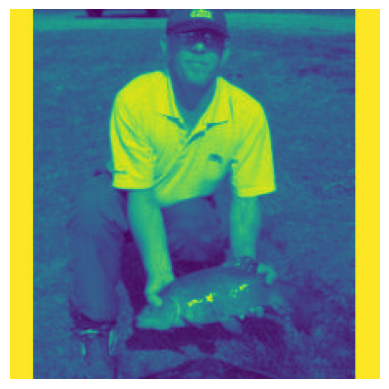

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total parametrs: ", count_parameters(model))


Total parametrs:  24511329


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 1, LR: 0.001000, Loss: 0.9238


Epoch 1, Batch 2, LR: 0.001000, Loss: 1.1050


Epoch 1, Batch 3, LR: 0.001000, Loss: 0.7882


Epoch 1, Batch 4, LR: 0.001000, Loss: 0.7000


Epoch 1, Batch 5, LR: 0.001000, Loss: 0.6743


Epoch 1, Batch 6, LR: 0.001000, Loss: 0.6644


Epoch 1, Batch 7, LR: 0.001000, Loss: 0.6544


Epoch 1, Batch 8, LR: 0.001000, Loss: 0.6387


Epoch 1, Batch 9, LR: 0.001000, Loss: 0.6390


Epoch 1, Batch 10, LR: 0.001000, Loss: 0.6156


Epoch 1, Batch 11, LR: 0.001000, Loss: 0.6198


Epoch 1, Batch 12, LR: 0.001000, Loss: 0.6207


Epoch 1, Batch 13, LR: 0.001000, Loss: 0.6080


Epoch 1, Batch 14, LR: 0.001000, Loss: 0.5882


Epoch 1, Batch 15, LR: 0.001000, Loss: 0.6040


Epoch 1, Batch 16, LR: 0.001000, Loss: 0.5974


Epoch 1, Batch 17, LR: 0.001000, Loss: 0.5828


Epoch 1, Batch 18, LR: 0.001000, Loss: 0.5971


Epoch 1, Batch 19, LR: 0.001000, Loss: 0.5773


Epoch 1, Batch 20, LR: 0.001000, Loss: 0.5794


Epoch 1, Batch 21, LR: 0.001000, Loss: 0.5841


Epoch 1, Batch 22, LR: 0.001000, Loss: 0.5976


Epoch 1, Batch 23, LR: 0.001000, Loss: 0.6013


Epoch 1, Batch 24, LR: 0.001000, Loss: 0.6174


Epoch 1, Batch 25, LR: 0.001000, Loss: 0.5954


Epoch 1, Batch 26, LR: 0.001000, Loss: 0.5938


Epoch 1, Batch 27, LR: 0.001000, Loss: 0.5864


Epoch 1, Batch 28, LR: 0.001000, Loss: 0.6027


Epoch 1, Batch 29, LR: 0.000999, Loss: 0.5997


Epoch 1, Batch 30, LR: 0.000999, Loss: 0.6012


Epoch 1, Batch 31, LR: 0.000999, Loss: 0.5655


Epoch 1, Batch 32, LR: 0.000999, Loss: 0.5754


Epoch 1, Batch 33, LR: 0.000999, Loss: 0.5907


Epoch 1, Batch 34, LR: 0.000999, Loss: 0.5955


Epoch 1, Batch 35, LR: 0.000999, Loss: 0.5296


Epoch 1, Batch 36, LR: 0.000999, Loss: 0.5507


Epoch 1, Batch 37, LR: 0.000999, Loss: 0.5534


Epoch 1, Batch 38, LR: 0.000999, Loss: 0.5748


Epoch 1, Batch 39, LR: 0.000999, Loss: 0.6232


Epoch 1, Batch 40, LR: 0.000999, Loss: 0.5869


Epoch 1, Batch 41, LR: 0.000999, Loss: 0.6260


Epoch 1, Batch 42, LR: 0.000999, Loss: 0.6011


Epoch 1, Batch 43, LR: 0.000999, Loss: 0.6157


Epoch 1, Batch 44, LR: 0.000999, Loss: 0.6000


Epoch 1, Batch 45, LR: 0.000999, Loss: 0.6185


Epoch 1, Batch 46, LR: 0.000999, Loss: 0.6171


Epoch 1, Batch 47, LR: 0.000999, Loss: 0.6087


Epoch 1, Batch 48, LR: 0.000999, Loss: 0.6084


Epoch 1, Batch 49, LR: 0.000999, Loss: 0.6127


Epoch 1, Batch 50, LR: 0.000998, Loss: 0.6005


Epoch 1, Batch 51, LR: 0.000998, Loss: 0.6047


Epoch 1, Batch 52, LR: 0.000998, Loss: 0.6024


Epoch 1, Batch 53, LR: 0.000998, Loss: 0.5941


Epoch 1, Batch 54, LR: 0.000998, Loss: 0.6072


Epoch 1, Batch 55, LR: 0.000998, Loss: 0.6152


Epoch 1, Batch 56, LR: 0.000998, Loss: 0.6131


Epoch 1, Batch 57, LR: 0.000998, Loss: 0.6029


Epoch 1, Batch 58, LR: 0.000998, Loss: 0.6176


Epoch 1, Batch 59, LR: 0.000998, Loss: 0.6299


Epoch 1, Batch 60, LR: 0.000998, Loss: 0.6104


Epoch 1, Batch 61, LR: 0.000998, Loss: 0.6145


Epoch 1, Batch 62, LR: 0.000998, Loss: 0.5994


Epoch 1, Batch 63, LR: 0.000998, Loss: 0.6150


Epoch 1, Batch 64, LR: 0.000997, Loss: 0.5924


Epoch 1, Batch 65, LR: 0.000997, Loss: 0.6117


Epoch 1, Batch 66, LR: 0.000997, Loss: 0.6059


Epoch 1, Batch 67, LR: 0.000997, Loss: 0.6012


Epoch 1, Batch 68, LR: 0.000997, Loss: 0.5913


Epoch 1, Batch 69, LR: 0.000997, Loss: 0.5953


Epoch 1, Batch 70, LR: 0.000997, Loss: 0.6093


Epoch 1, Batch 71, LR: 0.000997, Loss: 0.5946


Epoch 1, Batch 72, LR: 0.000997, Loss: 0.5791


Epoch 1, Batch 73, LR: 0.000997, Loss: 0.5859


Epoch 1, Batch 74, LR: 0.000997, Loss: 0.5939


Epoch 1, Batch 75, LR: 0.000997, Loss: 0.6120


Epoch 1, Batch 76, LR: 0.000996, Loss: 0.6028


Epoch 1, Batch 77, LR: 0.000996, Loss: 0.6129


Epoch 1, Batch 78, LR: 0.000996, Loss: 0.6045


Epoch 1, Batch 79, LR: 0.000996, Loss: 0.6052


Epoch 1, Batch 80, LR: 0.000996, Loss: 0.5886


Epoch 1, Batch 81, LR: 0.000996, Loss: 0.6036


Epoch 1, Batch 82, LR: 0.000996, Loss: 0.5945


Epoch 1, Batch 83, LR: 0.000996, Loss: 0.5889


Epoch 1, Batch 84, LR: 0.000996, Loss: 0.5977


Epoch 1, Batch 85, LR: 0.000996, Loss: 0.5847


Epoch 1, Batch 86, LR: 0.000995, Loss: 0.5899


Epoch 1, Batch 87, LR: 0.000995, Loss: 0.6168


Epoch 1, Batch 88, LR: 0.000995, Loss: 0.5872


Epoch 1, Batch 89, LR: 0.000995, Loss: 0.5743


Epoch 1, Batch 90, LR: 0.000995, Loss: 0.5686


Epoch 1, Batch 91, LR: 0.000995, Loss: 0.5687


Epoch 1, Batch 92, LR: 0.000995, Loss: 0.5877


Epoch 1, Batch 93, LR: 0.000995, Loss: 0.5934


Epoch 1, Batch 94, LR: 0.000995, Loss: 0.5833


Epoch 1, Batch 95, LR: 0.000994, Loss: 0.5945


Epoch 1, Batch 96, LR: 0.000994, Loss: 0.5949


Epoch 1, Batch 97, LR: 0.000994, Loss: 0.5888


Epoch 1, Batch 98, LR: 0.000994, Loss: 0.5817


Epoch 1, Batch 99, LR: 0.000994, Loss: 0.5729


Epoch 1, Batch 100, LR: 0.000994, Loss: 0.5900


Epoch 1, Batch 101, LR: 0.000994, Loss: 0.5936


Epoch 1, Batch 102, LR: 0.000994, Loss: 0.5814


Epoch 1, Batch 103, LR: 0.000993, Loss: 0.5597


Epoch 1, Batch 104, LR: 0.000993, Loss: 0.5536


Epoch 1, Batch 105, LR: 0.000993, Loss: 0.5783


Epoch 1, Batch 106, LR: 0.000993, Loss: 0.5884


Epoch 1, Batch 107, LR: 0.000993, Loss: 0.6138


Epoch 1, Batch 108, LR: 0.000993, Loss: 0.6043


Epoch 1, Batch 109, LR: 0.000993, Loss: 0.6014


Epoch 1, Batch 110, LR: 0.000993, Loss: 0.6061


Epoch 1, Batch 111, LR: 0.000992, Loss: 0.5325


Epoch 1, Batch 112, LR: 0.000992, Loss: 0.5616


Epoch 1, Batch 113, LR: 0.000992, Loss: 0.5714


Epoch 1, Batch 114, LR: 0.000992, Loss: 0.5816


Epoch 1, Batch 115, LR: 0.000992, Loss: 0.5341


Epoch 1, Batch 116, LR: 0.000992, Loss: 0.5695


Epoch 1, Batch 117, LR: 0.000992, Loss: 0.5716


Epoch 1, Batch 118, LR: 0.000991, Loss: 0.5581


Epoch 1, Batch 119, LR: 0.000991, Loss: 0.5220


Epoch 1, Batch 120, LR: 0.000991, Loss: 0.5839


Epoch 1, Batch 121, LR: 0.000991, Loss: 0.5533


Epoch 1, Batch 122, LR: 0.000991, Loss: 0.5640


Epoch 1, Batch 123, LR: 0.000991, Loss: 0.6724


Epoch 1, Batch 124, LR: 0.000991, Loss: 0.6664


Epoch 1, Batch 125, LR: 0.000990, Loss: 0.6277


Epoch 1, Batch 126, LR: 0.000990, Loss: 0.6326


Epoch 1, Batch 127, LR: 0.000990, Loss: 0.6290


Epoch 1, Batch 128, LR: 0.000990, Loss: 0.6274


Epoch 1, Batch 129, LR: 0.000990, Loss: 0.6439


Epoch 1, Batch 130, LR: 0.000990, Loss: 0.6314


Epoch 1, Batch 131, LR: 0.000989, Loss: 0.6260


Epoch 1, Batch 132, LR: 0.000989, Loss: 0.6142


Epoch 1, Batch 133, LR: 0.000989, Loss: 0.6303


Epoch 1, Batch 134, LR: 0.000989, Loss: 0.6141


Epoch 1, Batch 135, LR: 0.000989, Loss: 0.6164


Epoch 1, Batch 136, LR: 0.000989, Loss: 0.6237


Epoch 1, Batch 137, LR: 0.000988, Loss: 0.6359


Epoch 1, Batch 138, LR: 0.000988, Loss: 0.6292


Epoch 1, Batch 139, LR: 0.000988, Loss: 0.6279


Epoch 1, Batch 140, LR: 0.000988, Loss: 0.6315


Epoch 1, Batch 141, LR: 0.000988, Loss: 0.6243


Epoch 1, Batch 142, LR: 0.000988, Loss: 0.5937


Epoch 1, Batch 143, LR: 0.000987, Loss: 0.5968


Epoch 1, Batch 144, LR: 0.000987, Loss: 0.5960


Epoch 1, Batch 145, LR: 0.000987, Loss: 0.6423


Epoch 1, Batch 146, LR: 0.000987, Loss: 0.5940


Epoch 1, Batch 147, LR: 0.000987, Loss: 0.5907


Epoch 1, Batch 148, LR: 0.000987, Loss: 0.5916


Epoch 1, Batch 149, LR: 0.000986, Loss: 0.5849


Epoch 1, Batch 150, LR: 0.000986, Loss: 0.5757


Epoch 1, Batch 151, LR: 0.000986, Loss: 0.5703


Epoch 1, Batch 152, LR: 0.000986, Loss: 0.5748


Epoch 1, Batch 153, LR: 0.000986, Loss: 0.5725


Epoch 1, Batch 154, LR: 0.000985, Loss: 0.5709


Epoch 1, Batch 155, LR: 0.000985, Loss: 0.5730


Epoch 1, Batch 156, LR: 0.000985, Loss: 0.5705


Epoch 1, Batch 157, LR: 0.000985, Loss: 0.5787


Epoch 1, Batch 158, LR: 0.000985, Loss: 0.5686


Epoch 1, Batch 159, LR: 0.000984, Loss: 0.5805


Epoch 1, Batch 160, LR: 0.000984, Loss: 0.6050


Epoch 1, Batch 161, LR: 0.000984, Loss: 0.5726


Epoch 1, Batch 162, LR: 0.000984, Loss: 0.5826


Epoch 1, Batch 163, LR: 0.000984, Loss: 0.5827


Epoch 1, Batch 164, LR: 0.000984, Loss: 0.5817


Epoch 1, Batch 165, LR: 0.000983, Loss: 0.5695


Epoch 1, Batch 166, LR: 0.000983, Loss: 0.5842


Epoch 1, Batch 167, LR: 0.000983, Loss: 0.5782


Epoch 1, Batch 168, LR: 0.000983, Loss: 0.5780


Epoch 1, Batch 169, LR: 0.000982, Loss: 0.5819


Epoch 1, Batch 170, LR: 0.000982, Loss: 0.5830


Epoch 1, Batch 171, LR: 0.000982, Loss: 0.5967


Epoch 1, Batch 172, LR: 0.000982, Loss: 0.5954


Epoch 1, Batch 173, LR: 0.000982, Loss: 0.6286


Epoch 1, Batch 174, LR: 0.000981, Loss: 0.6174


Epoch 1, Batch 175, LR: 0.000981, Loss: 0.5967


Epoch 1, Batch 176, LR: 0.000981, Loss: 0.5931


Epoch 1, Batch 177, LR: 0.000981, Loss: 0.5914


Epoch 1, Batch 178, LR: 0.000981, Loss: 0.5879


Epoch 1, Batch 179, LR: 0.000980, Loss: 0.5857


Epoch 1, Batch 180, LR: 0.000980, Loss: 0.5678


Epoch 1, Batch 181, LR: 0.000980, Loss: 0.5871


Epoch 1, Batch 182, LR: 0.000980, Loss: 0.6048


Epoch 1, Batch 183, LR: 0.000979, Loss: 0.5975


Epoch 1, Batch 184, LR: 0.000979, Loss: 0.5963


Epoch 1, Batch 185, LR: 0.000979, Loss: 0.5968


Epoch 1, Batch 186, LR: 0.000979, Loss: 0.5820


Epoch 1, Batch 187, LR: 0.000979, Loss: 0.5880


Epoch 1, Batch 188, LR: 0.000978, Loss: 0.5822


Epoch 1, Batch 189, LR: 0.000978, Loss: 0.5761


Epoch 1, Batch 190, LR: 0.000978, Loss: 0.6168


Epoch 1, Batch 191, LR: 0.000978, Loss: 0.5988


Epoch 1, Batch 192, LR: 0.000977, Loss: 0.6027


Epoch 1, Batch 193, LR: 0.000977, Loss: 0.5834


Epoch 1, Batch 194, LR: 0.000977, Loss: 0.5976


Epoch 1, Batch 195, LR: 0.000977, Loss: 0.5903


Epoch 1, Batch 196, LR: 0.000976, Loss: 0.6279


Epoch 1, Batch 197, LR: 0.000976, Loss: 0.6019


Epoch 1, Batch 198, LR: 0.000976, Loss: 0.5875


Epoch 1, Batch 199, LR: 0.000976, Loss: 0.5853


Epoch 1, Batch 200, LR: 0.000976, Loss: 0.5932


Epoch 1, Batch 201, LR: 0.000975, Loss: 0.5804


Epoch 1, Batch 202, LR: 0.000975, Loss: 0.5610


Epoch 1, Batch 203, LR: 0.000975, Loss: 0.5854


Epoch 1, Batch 204, LR: 0.000975, Loss: 0.6088


Epoch 1, Batch 205, LR: 0.000974, Loss: 0.6403


Epoch 1, Batch 206, LR: 0.000974, Loss: 0.6266


Epoch 1, Batch 207, LR: 0.000974, Loss: 0.6144


Epoch 1, Batch 208, LR: 0.000974, Loss: 0.6058


Epoch 1, Batch 209, LR: 0.000973, Loss: 0.5917


Epoch 1, Batch 210, LR: 0.000973, Loss: 0.5966


Epoch 1, Batch 211, LR: 0.000973, Loss: 0.5964


Epoch 1, Batch 212, LR: 0.000973, Loss: 0.5660


Epoch 1, Batch 213, LR: 0.000972, Loss: 0.5888


Epoch 1, Batch 214, LR: 0.000972, Loss: 0.5772


Epoch 1, Batch 215, LR: 0.000972, Loss: 0.5822


Epoch 1, Batch 216, LR: 0.000971, Loss: 0.5894


Epoch 1, Batch 217, LR: 0.000971, Loss: 0.5856


Epoch 1, Batch 218, LR: 0.000971, Loss: 0.5805


Epoch 1, Batch 219, LR: 0.000971, Loss: 0.5666


Epoch 1, Batch 220, LR: 0.000970, Loss: 0.5586


Epoch 1, Batch 221, LR: 0.000970, Loss: 0.5626


Epoch 1, Batch 222, LR: 0.000970, Loss: 0.5613


Epoch 1, Batch 223, LR: 0.000970, Loss: 0.5718


Epoch 1, Batch 224, LR: 0.000969, Loss: 0.6073


Epoch 1, Batch 225, LR: 0.000969, Loss: 0.5982


Epoch 1, Batch 226, LR: 0.000969, Loss: 0.6160


Epoch 1, Batch 227, LR: 0.000969, Loss: 0.6348


Epoch 1, Batch 228, LR: 0.000968, Loss: 0.6093


Epoch 1, Batch 229, LR: 0.000968, Loss: 0.6197


Epoch 1, Batch 230, LR: 0.000968, Loss: 0.6152


Epoch 1, Batch 231, LR: 0.000967, Loss: 0.6213


Epoch 1, Batch 232, LR: 0.000967, Loss: 0.6011


Epoch 1, Batch 233, LR: 0.000967, Loss: 0.6150


Epoch 1, Batch 234, LR: 0.000967, Loss: 0.6125


Epoch 1, Batch 235, LR: 0.000966, Loss: 0.6061


Epoch 1, Batch 236, LR: 0.000966, Loss: 0.5969


Epoch 1, Batch 237, LR: 0.000966, Loss: 0.5984


Epoch 1, Batch 238, LR: 0.000965, Loss: 0.6132


Epoch 1, Batch 239, LR: 0.000965, Loss: 0.6311


Epoch 1, Batch 240, LR: 0.000965, Loss: 0.6323


Epoch 1, Batch 241, LR: 0.000965, Loss: 0.6106


Epoch 1, Batch 242, LR: 0.000964, Loss: 0.6005


Epoch 1, Batch 243, LR: 0.000964, Loss: 0.6103


Epoch 1, Batch 244, LR: 0.000964, Loss: 0.6057


Epoch 1, Batch 245, LR: 0.000963, Loss: 0.6138


Epoch 1, Batch 246, LR: 0.000963, Loss: 0.6077


Epoch 1, Batch 247, LR: 0.000963, Loss: 0.6315


Epoch 1, Batch 248, LR: 0.000963, Loss: 0.6258


Epoch 1, Batch 249, LR: 0.000962, Loss: 0.6157


Epoch 1, Batch 250, LR: 0.000962, Loss: 0.6146


Epoch 1, Batch 251, LR: 0.000962, Loss: 0.6301


Epoch 1, Batch 252, LR: 0.000961, Loss: 0.6167


Epoch 1, Batch 253, LR: 0.000961, Loss: 0.6248


Epoch 1, Batch 254, LR: 0.000961, Loss: 0.6153


Epoch 1, Batch 255, LR: 0.000960, Loss: 0.6067


Epoch 1, Batch 256, LR: 0.000960, Loss: 0.6003


Epoch 1, Batch 257, LR: 0.000960, Loss: 0.6267


Epoch 1, Batch 258, LR: 0.000959, Loss: 0.6181


Epoch 1, Batch 259, LR: 0.000959, Loss: 0.6119


Epoch 1, Batch 260, LR: 0.000959, Loss: 0.6043


Epoch 1, Batch 261, LR: 0.000959, Loss: 0.6002


Epoch 1, Batch 262, LR: 0.000958, Loss: 0.6304


Epoch 1, Batch 263, LR: 0.000958, Loss: 0.6380


Epoch 1, Batch 264, LR: 0.000958, Loss: 0.6119


Epoch 1, Batch 265, LR: 0.000957, Loss: 0.6228


Epoch 1, Batch 266, LR: 0.000957, Loss: 0.5893


Epoch 1, Batch 267, LR: 0.000957, Loss: 0.6041


Epoch 1, Batch 268, LR: 0.000956, Loss: 0.5947


Epoch 1, Batch 269, LR: 0.000956, Loss: 0.5957


Epoch 1, Batch 270, LR: 0.000956, Loss: 0.6215


Epoch 1, Batch 271, LR: 0.000955, Loss: 0.6133


Epoch 1, Batch 272, LR: 0.000955, Loss: 0.6049


Epoch 1, Batch 273, LR: 0.000955, Loss: 0.5962


Epoch 1, Batch 274, LR: 0.000954, Loss: 0.6174


Epoch 1, Batch 275, LR: 0.000954, Loss: 0.6037


Epoch 1, Batch 276, LR: 0.000954, Loss: 0.6032


Epoch 1, Batch 277, LR: 0.000953, Loss: 0.5974


Epoch 1, Batch 278, LR: 0.000953, Loss: 0.5951


Epoch 1, Batch 279, LR: 0.000953, Loss: 0.6239


Epoch 1, Batch 280, LR: 0.000952, Loss: 0.6085


Epoch 1, Batch 281, LR: 0.000952, Loss: 0.5939


Epoch 1, Batch 282, LR: 0.000952, Loss: 0.6201


Epoch 1, Batch 283, LR: 0.000951, Loss: 0.6162


Epoch 1, Batch 284, LR: 0.000951, Loss: 0.6163


Epoch 1, Batch 285, LR: 0.000951, Loss: 0.6207


Epoch 1, Batch 286, LR: 0.000950, Loss: 0.6105


Epoch 1, Batch 287, LR: 0.000950, Loss: 0.6189


Epoch 1, Batch 288, LR: 0.000950, Loss: 0.6208


Epoch 1, Batch 289, LR: 0.000949, Loss: 0.6196


Epoch 1, Batch 290, LR: 0.000949, Loss: 0.6363


Epoch 1, Batch 291, LR: 0.000949, Loss: 0.6196


Epoch 1, Batch 292, LR: 0.000948, Loss: 0.6159


Epoch 1, Batch 293, LR: 0.000948, Loss: 0.6074


Epoch 1, Batch 294, LR: 0.000948, Loss: 0.6199


Epoch 1, Batch 295, LR: 0.000947, Loss: 0.6136


Epoch 1, Batch 296, LR: 0.000947, Loss: 0.6169


Epoch 1, Batch 297, LR: 0.000947, Loss: 0.6318


Epoch 1, Batch 298, LR: 0.000946, Loss: 0.6153


Epoch 1, Batch 299, LR: 0.000946, Loss: 0.6174


Epoch 1, Batch 300, LR: 0.000946, Loss: 0.6284


Epoch 1, Batch 301, LR: 0.000945, Loss: 0.6230


Epoch 1, Batch 302, LR: 0.000945, Loss: 0.6297


Epoch 1, Batch 303, LR: 0.000944, Loss: 0.6327


Epoch 1, Batch 304, LR: 0.000944, Loss: 0.6313


Epoch 1, Batch 305, LR: 0.000944, Loss: 0.6096


Epoch 1, Batch 306, LR: 0.000943, Loss: 0.6282


Epoch 1, Batch 307, LR: 0.000943, Loss: 0.6220


Epoch 1, Batch 308, LR: 0.000943, Loss: 0.5993


Epoch 1, Batch 309, LR: 0.000942, Loss: 0.6278


Epoch 1, Batch 310, LR: 0.000942, Loss: 0.6159


Epoch 1, Batch 311, LR: 0.000942, Loss: 0.6075


Epoch 1, Batch 312, LR: 0.000941, Loss: 0.6167


Epoch 1, Batch 313, LR: 0.000941, Loss: 0.6194


Epoch 1, Batch 314, LR: 0.000940, Loss: 0.6053


Epoch 1, Batch 315, LR: 0.000940, Loss: 0.6196


Epoch 1, Batch 316, LR: 0.000940, Loss: 0.6065


Epoch 1, Batch 317, LR: 0.000939, Loss: 0.6098


Epoch 1, Batch 318, LR: 0.000939, Loss: 0.6403


Epoch 1, Batch 319, LR: 0.000939, Loss: 0.6124


Epoch 1, Batch 320, LR: 0.000938, Loss: 0.6204


Epoch 1, Batch 321, LR: 0.000938, Loss: 0.6238


Epoch 1, Batch 322, LR: 0.000937, Loss: 0.6237


Epoch 1, Batch 323, LR: 0.000937, Loss: 0.6175


Epoch 1, Batch 324, LR: 0.000937, Loss: 0.6119


Epoch 1, Batch 325, LR: 0.000936, Loss: 0.6185


Epoch 1, Batch 326, LR: 0.000936, Loss: 0.6022


Epoch 1, Batch 327, LR: 0.000935, Loss: 0.6076


Epoch 1, Batch 328, LR: 0.000935, Loss: 0.6230


Epoch 1, Batch 329, LR: 0.000935, Loss: 0.6057


Epoch 1, Batch 330, LR: 0.000934, Loss: 0.6015


Epoch 1, Batch 331, LR: 0.000934, Loss: 0.6107


Epoch 1, Batch 332, LR: 0.000934, Loss: 0.5968


Epoch 1, Batch 333, LR: 0.000933, Loss: 0.5946


Epoch 1, Batch 334, LR: 0.000933, Loss: 0.6002


Epoch 1, Batch 335, LR: 0.000932, Loss: 0.6179


Epoch 1, Batch 336, LR: 0.000932, Loss: 0.5976


Epoch 1, Batch 337, LR: 0.000932, Loss: 0.6089


Epoch 1, Batch 338, LR: 0.000931, Loss: 0.6266


Epoch 1, Batch 339, LR: 0.000931, Loss: 0.6049


Epoch 1, Batch 340, LR: 0.000930, Loss: 0.6051


Epoch 1, Batch 341, LR: 0.000930, Loss: 0.6185


Epoch 1, Batch 342, LR: 0.000930, Loss: 0.6167


Epoch 1, Batch 343, LR: 0.000929, Loss: 0.5990


Epoch 1, Batch 344, LR: 0.000929, Loss: 0.6092


Epoch 1, Batch 345, LR: 0.000928, Loss: 0.6045


Epoch 1, Batch 346, LR: 0.000928, Loss: 0.6067


Epoch 1, Batch 347, LR: 0.000928, Loss: 0.6079


Epoch 1, Batch 348, LR: 0.000927, Loss: 0.6120


Epoch 1, Batch 349, LR: 0.000927, Loss: 0.6328


Epoch 1, Batch 350, LR: 0.000926, Loss: 0.6059


Epoch 1, Batch 351, LR: 0.000926, Loss: 0.6093


Epoch 1, Batch 352, LR: 0.000925, Loss: 0.6026


Epoch 1, Batch 353, LR: 0.000925, Loss: 0.6032


Epoch 1, Batch 354, LR: 0.000925, Loss: 0.6055


Epoch 1, Batch 355, LR: 0.000924, Loss: 0.6012


Epoch 1, Batch 356, LR: 0.000924, Loss: 0.6274


Epoch 1, Batch 357, LR: 0.000923, Loss: 0.6319


Epoch 1, Batch 358, LR: 0.000923, Loss: 0.6093


Epoch 1, Batch 359, LR: 0.000923, Loss: 0.6101


Epoch 1, Batch 360, LR: 0.000922, Loss: 0.6127


Epoch 1, Batch 361, LR: 0.000922, Loss: 0.6156


Epoch 1, Batch 362, LR: 0.000921, Loss: 0.6164


Epoch 1, Batch 363, LR: 0.000921, Loss: 0.5960


Epoch 1, Batch 364, LR: 0.000920, Loss: 0.6089


Epoch 1, Batch 365, LR: 0.000920, Loss: 0.6051


Epoch 1, Batch 366, LR: 0.000920, Loss: 0.5910


Epoch 1, Batch 367, LR: 0.000919, Loss: 0.6004


Epoch 1, Batch 368, LR: 0.000919, Loss: 0.5916


Epoch 1, Batch 369, LR: 0.000918, Loss: 0.5846


Epoch 1, Batch 370, LR: 0.000918, Loss: 0.5710


Epoch 1, Batch 371, LR: 0.000917, Loss: 0.5686


Epoch 1, Batch 372, LR: 0.000917, Loss: 0.5816


Epoch 1, Batch 373, LR: 0.000917, Loss: 0.5773


Epoch 1, Batch 374, LR: 0.000916, Loss: 0.5781


Epoch 1, Batch 375, LR: 0.000916, Loss: 0.5936


Epoch 1, Batch 376, LR: 0.000915, Loss: 0.5831


Epoch 1, Batch 377, LR: 0.000915, Loss: 0.5860


Epoch 1, Batch 378, LR: 0.000914, Loss: 0.5919


Epoch 1, Batch 379, LR: 0.000914, Loss: 0.5707


Epoch 1, Batch 380, LR: 0.000914, Loss: 0.5802


Epoch 1, Batch 381, LR: 0.000913, Loss: 0.5942


Epoch 1, Batch 382, LR: 0.000913, Loss: 0.5868


Epoch 1, Batch 383, LR: 0.000912, Loss: 0.5800


Epoch 1, Batch 384, LR: 0.000912, Loss: 0.5725


Epoch 1, Batch 385, LR: 0.000911, Loss: 0.5702


Epoch 1, Batch 386, LR: 0.000911, Loss: 0.5857


Epoch 1, Batch 387, LR: 0.000910, Loss: 0.6045


Epoch 1, Batch 388, LR: 0.000910, Loss: 0.5863


Epoch 1, Batch 389, LR: 0.000910, Loss: 0.6134


Epoch 1, Batch 390, LR: 0.000909, Loss: 0.6625


Epoch 1, Batch 391, LR: 0.000909, Loss: 0.6015


Epoch 1, Batch 392, LR: 0.000908, Loss: 0.6047


Epoch 1, Batch 393, LR: 0.000908, Loss: 0.6087


Epoch 1, Batch 394, LR: 0.000907, Loss: 0.6048


Epoch 1, Batch 395, LR: 0.000907, Loss: 0.6035


Epoch 1, Batch 396, LR: 0.000906, Loss: 0.6093


Epoch 1, Batch 397, LR: 0.000906, Loss: 0.5900


Epoch 1, Batch 398, LR: 0.000905, Loss: 0.6061


Epoch 1, Batch 399, LR: 0.000905, Loss: 0.6086


Epoch 1, Batch 400, LR: 0.000905, Loss: 0.5892


Epoch 1, Batch 401, LR: 0.000904, Loss: 0.5892


Epoch 1, Batch 402, LR: 0.000904, Loss: 0.6008


Epoch 1, Batch 403, LR: 0.000903, Loss: 0.6015


Epoch 1, Batch 404, LR: 0.000903, Loss: 0.6014


Epoch 1, Batch 405, LR: 0.000902, Loss: 0.5936


Epoch 1, Batch 406, LR: 0.000902, Loss: 0.5901


Epoch 1, Batch 407, LR: 0.000901, Loss: 0.5923


Epoch 1, Batch 408, LR: 0.000901, Loss: 0.5960


Epoch 1, Batch 409, LR: 0.000900, Loss: 0.6079


Epoch 1, Batch 410, LR: 0.000900, Loss: 0.6057


Epoch 1, Batch 411, LR: 0.000899, Loss: 0.5914


Epoch 1, Batch 412, LR: 0.000899, Loss: 0.5961


Epoch 1, Batch 413, LR: 0.000898, Loss: 0.6113


Epoch 1, Batch 414, LR: 0.000898, Loss: 0.6078


Epoch 1, Batch 415, LR: 0.000897, Loss: 0.5955


Epoch 1, Batch 416, LR: 0.000897, Loss: 0.5887


Epoch 1, Batch 417, LR: 0.000897, Loss: 0.5861


Epoch 1, Batch 418, LR: 0.000896, Loss: 0.5936


Epoch 1, Batch 419, LR: 0.000896, Loss: 0.6041


Epoch 1, Batch 420, LR: 0.000895, Loss: 0.6213


Epoch 1, Batch 421, LR: 0.000895, Loss: 0.5914


Epoch 1, Batch 422, LR: 0.000894, Loss: 0.6026


Epoch 1, Batch 423, LR: 0.000894, Loss: 0.6123


Epoch 1, Batch 424, LR: 0.000893, Loss: 0.6097


Epoch 1, Batch 425, LR: 0.000893, Loss: 0.6083


Epoch 1, Batch 426, LR: 0.000892, Loss: 0.6027


Epoch 1, Batch 427, LR: 0.000892, Loss: 0.5933


Epoch 1, Batch 428, LR: 0.000891, Loss: 0.5995


Epoch 1, Batch 429, LR: 0.000891, Loss: 0.6197


Epoch 1, Batch 430, LR: 0.000890, Loss: 0.5904


Epoch 1, Batch 431, LR: 0.000890, Loss: 0.6628


Epoch 1, Batch 432, LR: 0.000889, Loss: 0.6010


Epoch 1, Batch 433, LR: 0.000889, Loss: 0.5911


Epoch 1, Batch 434, LR: 0.000888, Loss: 0.5930


Epoch 1, Batch 435, LR: 0.000888, Loss: 0.5992


Epoch 1, Batch 436, LR: 0.000887, Loss: 0.5803


Epoch 1, Batch 437, LR: 0.000887, Loss: 0.5765


Epoch 1, Batch 438, LR: 0.000886, Loss: 0.5983


Epoch 1, Batch 439, LR: 0.000886, Loss: 0.6068


Epoch 1, Batch 440, LR: 0.000885, Loss: 0.5743


Epoch 1, Batch 441, LR: 0.000885, Loss: 0.5767


Epoch 1, Batch 442, LR: 0.000884, Loss: 0.5647


Epoch 1, Batch 443, LR: 0.000884, Loss: 0.5893


Epoch 1, Batch 444, LR: 0.000883, Loss: 0.5872


Epoch 1, Batch 445, LR: 0.000883, Loss: 0.5882


Epoch 1, Batch 446, LR: 0.000882, Loss: 0.6143


Epoch 1, Batch 447, LR: 0.000882, Loss: 0.6028


Epoch 1, Batch 448, LR: 0.000881, Loss: 0.5695


Epoch 1, Batch 449, LR: 0.000881, Loss: 0.6013


Epoch 1, Batch 450, LR: 0.000880, Loss: 0.5593


Epoch 1, Batch 451, LR: 0.000880, Loss: 0.5526


Epoch 1, Batch 452, LR: 0.000879, Loss: 0.5653


Epoch 1, Batch 453, LR: 0.000879, Loss: 0.5515


Epoch 1, Batch 454, LR: 0.000878, Loss: 0.5679


Epoch 1, Batch 455, LR: 0.000878, Loss: 0.5370


Epoch 1, Batch 456, LR: 0.000877, Loss: 0.5234


Epoch 1, Batch 457, LR: 0.000877, Loss: 0.5412


Epoch 1, Batch 458, LR: 0.000876, Loss: 0.5564


Epoch 1, Batch 459, LR: 0.000876, Loss: 0.5259


Epoch 1, Batch 460, LR: 0.000875, Loss: 0.5369


Epoch 1, Batch 461, LR: 0.000875, Loss: 0.5371


Epoch 1, Batch 462, LR: 0.000874, Loss: 0.5269


Epoch 1, Batch 463, LR: 0.000873, Loss: 0.5308


Epoch 1, Batch 464, LR: 0.000873, Loss: 0.5262


Epoch 1, Batch 465, LR: 0.000872, Loss: 0.5269


Epoch 1, Batch 466, LR: 0.000872, Loss: 0.5693


Epoch 1, Batch 467, LR: 0.000871, Loss: 0.5499


Epoch 1, Batch 468, LR: 0.000871, Loss: 0.5588


Epoch 1, Batch 469, LR: 0.000870, Loss: 0.5663


Epoch 1, Batch 470, LR: 0.000870, Loss: 0.5591


Epoch 1, Batch 471, LR: 0.000869, Loss: 0.5577


Epoch 1, Batch 472, LR: 0.000869, Loss: 0.5659


Epoch 1, Batch 473, LR: 0.000868, Loss: 0.5718


Epoch 1, Batch 474, LR: 0.000868, Loss: 0.5843


Epoch 1, Batch 475, LR: 0.000867, Loss: 0.5798


Epoch 1, Batch 476, LR: 0.000867, Loss: 0.5765


Epoch 1, Batch 477, LR: 0.000866, Loss: 0.5983


Epoch 1, Batch 478, LR: 0.000866, Loss: 0.5727


Epoch 1, Batch 479, LR: 0.000865, Loss: 0.5692


Epoch 1, Batch 480, LR: 0.000864, Loss: 0.5848


Epoch 1, Batch 481, LR: 0.000864, Loss: 0.5583


Epoch 1, Batch 482, LR: 0.000863, Loss: 0.5679


Epoch 1, Batch 483, LR: 0.000863, Loss: 0.5674


Epoch 1, Batch 484, LR: 0.000862, Loss: 0.5728


Epoch 1, Batch 485, LR: 0.000862, Loss: 0.5657


Epoch 1, Batch 486, LR: 0.000861, Loss: 0.5780


Epoch 1, Batch 487, LR: 0.000861, Loss: 0.5477


Epoch 1, Batch 488, LR: 0.000860, Loss: 0.5956


Epoch 1, Batch 489, LR: 0.000860, Loss: 0.6061


Epoch 1, Batch 490, LR: 0.000859, Loss: 0.6025


Epoch 1, Batch 491, LR: 0.000859, Loss: 0.6110


Epoch 1, Batch 492, LR: 0.000858, Loss: 0.6100


Epoch 1, Batch 493, LR: 0.000857, Loss: 0.6109


Epoch 1, Batch 494, LR: 0.000857, Loss: 0.6155


Epoch 1, Batch 495, LR: 0.000856, Loss: 0.6129


Epoch 1, Batch 496, LR: 0.000856, Loss: 0.6182


Epoch 1, Batch 497, LR: 0.000855, Loss: 0.6047


Epoch 1, Batch 498, LR: 0.000855, Loss: 0.6122


Epoch 1, Batch 499, LR: 0.000854, Loss: 0.6045


Epoch 1, Batch 500, LR: 0.000854, Loss: 0.6125


Epoch 1, Batch 501, LR: 0.000853, Loss: 0.6266


Epoch 1, Batch 502, LR: 0.000852, Loss: 0.6268


Epoch 1, Batch 503, LR: 0.000852, Loss: 0.6142


Epoch 1, Batch 504, LR: 0.000851, Loss: 0.6171


Epoch 1, Batch 505, LR: 0.000851, Loss: 0.6006


Epoch 1, Batch 506, LR: 0.000850, Loss: 0.5972


Epoch 1, Batch 507, LR: 0.000850, Loss: 0.6184


Epoch 1, Batch 508, LR: 0.000849, Loss: 0.6117


Epoch 1, Batch 509, LR: 0.000849, Loss: 0.5797


Epoch 1, Batch 510, LR: 0.000848, Loss: 0.5667


Epoch 1, Batch 511, LR: 0.000847, Loss: 0.5864


Epoch 1, Batch 512, LR: 0.000847, Loss: 0.5839


Epoch 1, Batch 513, LR: 0.000846, Loss: 0.5960


Epoch 1, Batch 514, LR: 0.000846, Loss: 0.5983


Epoch 1, Batch 515, LR: 0.000845, Loss: 0.5776


Epoch 1, Batch 516, LR: 0.000845, Loss: 0.5794


Epoch 1, Batch 517, LR: 0.000844, Loss: 0.5868


Epoch 1, Batch 518, LR: 0.000843, Loss: 0.5697


Epoch 1, Batch 519, LR: 0.000843, Loss: 0.5720


Epoch 1, Batch 520, LR: 0.000842, Loss: 0.5573


Epoch 1, Batch 521, LR: 0.000842, Loss: 0.5722


Epoch 1, Batch 522, LR: 0.000841, Loss: 0.5738


Epoch 1, Batch 523, LR: 0.000841, Loss: 0.5780


Epoch 1, Batch 524, LR: 0.000840, Loss: 0.5885


Epoch 1, Batch 525, LR: 0.000839, Loss: 0.5857


Epoch 1, Batch 526, LR: 0.000839, Loss: 0.5655


Epoch 1, Batch 527, LR: 0.000838, Loss: 0.5769


Epoch 1, Batch 528, LR: 0.000838, Loss: 0.5808


Epoch 1, Batch 529, LR: 0.000837, Loss: 0.5831


Epoch 1, Batch 530, LR: 0.000837, Loss: 0.5765


Epoch 1, Batch 531, LR: 0.000836, Loss: 0.5866


Epoch 1, Batch 532, LR: 0.000835, Loss: 0.5697


Epoch 1, Batch 533, LR: 0.000835, Loss: 0.5744


Epoch 1, Batch 534, LR: 0.000834, Loss: 0.5930


Epoch 1, Batch 535, LR: 0.000834, Loss: 0.5847


Epoch 1, Batch 536, LR: 0.000833, Loss: 0.5730


Epoch 1, Batch 537, LR: 0.000832, Loss: 0.5702


Epoch 1, Batch 538, LR: 0.000832, Loss: 0.5803


Epoch 1, Batch 539, LR: 0.000831, Loss: 0.5818


Epoch 1, Batch 540, LR: 0.000831, Loss: 0.5989


Epoch 1, Batch 541, LR: 0.000830, Loss: 0.5740


Epoch 1, Batch 542, LR: 0.000829, Loss: 0.5745


Epoch 1, Batch 543, LR: 0.000829, Loss: 0.5977


Epoch 1, Batch 544, LR: 0.000828, Loss: 0.6006


Epoch 1, Batch 545, LR: 0.000828, Loss: 0.5892


Epoch 1, Batch 546, LR: 0.000827, Loss: 0.6180


Epoch 1, Batch 547, LR: 0.000827, Loss: 0.5957


Epoch 1, Batch 548, LR: 0.000826, Loss: 0.5932


Epoch 1, Batch 549, LR: 0.000825, Loss: 0.5952


Epoch 1, Batch 550, LR: 0.000825, Loss: 0.6064


Epoch 1, Batch 551, LR: 0.000824, Loss: 0.6128


Epoch 1, Batch 552, LR: 0.000824, Loss: 0.5976


Epoch 1, Batch 553, LR: 0.000823, Loss: 0.6072


Epoch 1, Batch 554, LR: 0.000822, Loss: 0.6088


Epoch 1, Batch 555, LR: 0.000822, Loss: 0.5989


Epoch 1, Batch 556, LR: 0.000821, Loss: 0.5939


Epoch 1, Batch 557, LR: 0.000821, Loss: 0.6018


Epoch 1, Batch 558, LR: 0.000820, Loss: 0.5975


Epoch 1, Batch 559, LR: 0.000819, Loss: 0.6108


Epoch 1, Batch 560, LR: 0.000819, Loss: 0.6089


Epoch 1, Batch 561, LR: 0.000818, Loss: 0.5986


Epoch 1, Batch 562, LR: 0.000818, Loss: 0.5992


Epoch 1, Batch 563, LR: 0.000817, Loss: 0.5977


Epoch 1, Batch 564, LR: 0.000816, Loss: 0.6030


Epoch 1, Batch 565, LR: 0.000816, Loss: 0.6161


Epoch 1, Batch 566, LR: 0.000815, Loss: 0.6137


Epoch 1, Batch 567, LR: 0.000814, Loss: 0.6158


Epoch 1, Batch 568, LR: 0.000814, Loss: 0.6018


Epoch 1, Batch 569, LR: 0.000813, Loss: 0.5957


Epoch 1, Batch 570, LR: 0.000813, Loss: 0.5709


Epoch 1, Batch 571, LR: 0.000812, Loss: 0.5675


Epoch 1, Batch 572, LR: 0.000811, Loss: 0.5568


Epoch 1, Batch 573, LR: 0.000811, Loss: 0.5329


Epoch 1, Batch 574, LR: 0.000810, Loss: 0.5471


Epoch 1, Batch 575, LR: 0.000810, Loss: 0.5492


Epoch 1, Batch 576, LR: 0.000809, Loss: 0.5720


Epoch 1, Batch 577, LR: 0.000808, Loss: 0.5603


Epoch 1, Batch 578, LR: 0.000808, Loss: 0.5547


Epoch 1, Batch 579, LR: 0.000807, Loss: 0.5686


Epoch 1, Batch 580, LR: 0.000806, Loss: 0.5596


Epoch 1, Batch 581, LR: 0.000806, Loss: 0.5526


Epoch 1, Batch 582, LR: 0.000805, Loss: 0.5682


Epoch 1, Batch 583, LR: 0.000805, Loss: 0.5646


Epoch 1, Batch 584, LR: 0.000804, Loss: 0.5560


Epoch 1, Batch 585, LR: 0.000803, Loss: 0.5646


Epoch 1, Batch 586, LR: 0.000803, Loss: 0.5770


Epoch 1, Batch 587, LR: 0.000802, Loss: 0.5942


Epoch 1, Batch 588, LR: 0.000801, Loss: 0.5753


Epoch 1, Batch 589, LR: 0.000801, Loss: 0.5558


Epoch 1, Batch 590, LR: 0.000800, Loss: 0.5107


Epoch 1, Batch 591, LR: 0.000800, Loss: 0.5398


Epoch 1, Batch 592, LR: 0.000799, Loss: 0.5157


Epoch 1, Batch 593, LR: 0.000798, Loss: 0.5597


Epoch 1, Batch 594, LR: 0.000798, Loss: 0.5507


Epoch 1, Batch 595, LR: 0.000797, Loss: 0.5557


Epoch 1, Batch 596, LR: 0.000796, Loss: 0.5548


Epoch 1, Batch 597, LR: 0.000796, Loss: 0.5761


Epoch 1, Batch 598, LR: 0.000795, Loss: 0.5435


Epoch 1, Batch 599, LR: 0.000795, Loss: 0.5464


Epoch 1, Batch 600, LR: 0.000794, Loss: 0.5438


Epoch 1, Batch 601, LR: 0.000793, Loss: 0.5508


Epoch 1, Batch 602, LR: 0.000793, Loss: 0.5275


Epoch 1, Batch 603, LR: 0.000792, Loss: 0.5584


Epoch 1, Batch 604, LR: 0.000791, Loss: 0.5530


Epoch 1, Batch 605, LR: 0.000791, Loss: 0.5318


Epoch 1, Batch 606, LR: 0.000790, Loss: 0.5467


Epoch 1, Batch 607, LR: 0.000789, Loss: 0.5429


Epoch 1, Batch 608, LR: 0.000789, Loss: 0.5407


Epoch 1, Batch 609, LR: 0.000788, Loss: 0.5250


Epoch 1, Batch 610, LR: 0.000788, Loss: 0.5729


Epoch 1, Batch 611, LR: 0.000787, Loss: 0.6131


Epoch 1, Batch 612, LR: 0.000786, Loss: 0.6103


Epoch 1, Batch 613, LR: 0.000786, Loss: 0.6358


Epoch 1, Batch 614, LR: 0.000785, Loss: 0.6250


Epoch 1, Batch 615, LR: 0.000784, Loss: 0.5994


Epoch 1, Batch 616, LR: 0.000784, Loss: 0.5923


Epoch 1, Batch 617, LR: 0.000783, Loss: 0.6065


Epoch 1, Batch 618, LR: 0.000782, Loss: 0.5993


Epoch 1, Batch 619, LR: 0.000782, Loss: 0.5928


Epoch 1, Batch 620, LR: 0.000781, Loss: 0.5933


Epoch 1, Batch 621, LR: 0.000780, Loss: 0.5974


Epoch 1, Batch 622, LR: 0.000780, Loss: 0.6031


Epoch 1, Batch 623, LR: 0.000779, Loss: 0.5886


Epoch 1, Batch 624, LR: 0.000778, Loss: 0.5977


Epoch 1, Batch 625, LR: 0.000778, Loss: 0.6032


Epoch 1, Batch 626, LR: 0.000777, Loss: 0.6100


Epoch 1, Batch 627, LR: 0.000776, Loss: 0.6208


Epoch 1, Batch 628, LR: 0.000776, Loss: 0.6050


Epoch 1, Batch 629, LR: 0.000775, Loss: 0.6039


Epoch 1, Batch 630, LR: 0.000775, Loss: 0.5989


Epoch 1, Batch 631, LR: 0.000774, Loss: 0.5915


Epoch 1, Batch 632, LR: 0.000773, Loss: 0.5912


Epoch 1, Batch 633, LR: 0.000773, Loss: 0.6060


Epoch 1, Batch 634, LR: 0.000772, Loss: 0.5760


Epoch 1, Batch 635, LR: 0.000771, Loss: 0.5869


Epoch 1, Batch 636, LR: 0.000771, Loss: 0.5788


Epoch 1, Batch 637, LR: 0.000770, Loss: 0.5723


Epoch 1, Batch 638, LR: 0.000769, Loss: 0.5901


Epoch 1, Batch 639, LR: 0.000769, Loss: 0.5706


Epoch 1, Batch 640, LR: 0.000768, Loss: 0.5759


Epoch 1, Batch 641, LR: 0.000767, Loss: 0.5841


Epoch 1, Batch 642, LR: 0.000767, Loss: 0.5704


Epoch 1, Batch 643, LR: 0.000766, Loss: 0.5896


Epoch 1, Batch 644, LR: 0.000765, Loss: 0.5882


Epoch 1, Batch 645, LR: 0.000765, Loss: 0.5855


Epoch 1, Batch 646, LR: 0.000764, Loss: 0.5914


Epoch 1, Batch 647, LR: 0.000763, Loss: 0.5894


Epoch 1, Batch 648, LR: 0.000763, Loss: 0.5739


Epoch 1, Batch 649, LR: 0.000762, Loss: 0.5862


Epoch 1, Batch 650, LR: 0.000761, Loss: 0.5833


Epoch 1, Batch 651, LR: 0.000761, Loss: 0.5832


Epoch 1, Batch 652, LR: 0.000760, Loss: 0.6058


Epoch 1, Batch 653, LR: 0.000759, Loss: 0.5968


Epoch 1, Batch 654, LR: 0.000759, Loss: 0.5945


Epoch 1, Batch 655, LR: 0.000758, Loss: 0.5971


Epoch 1, Batch 656, LR: 0.000757, Loss: 0.6016


Epoch 1, Batch 657, LR: 0.000757, Loss: 0.6010


Epoch 1, Batch 658, LR: 0.000756, Loss: 0.5941


Epoch 1, Batch 659, LR: 0.000755, Loss: 0.5904


Epoch 1, Batch 660, LR: 0.000755, Loss: 0.5974


Epoch 1, Batch 661, LR: 0.000754, Loss: 0.5987


Epoch 1, Batch 662, LR: 0.000753, Loss: 0.5749


Epoch 1, Batch 663, LR: 0.000752, Loss: 0.5748


Epoch 1, Batch 664, LR: 0.000752, Loss: 0.5768


Epoch 1, Batch 665, LR: 0.000751, Loss: 0.5865


Epoch 1, Batch 666, LR: 0.000750, Loss: 0.5952


Epoch 1, Batch 667, LR: 0.000750, Loss: 0.5766


Epoch 1, Batch 668, LR: 0.000749, Loss: 0.6134


Epoch 1, Batch 669, LR: 0.000748, Loss: 0.5635


Epoch 1, Batch 670, LR: 0.000748, Loss: 0.5872


Epoch 1, Batch 671, LR: 0.000747, Loss: 0.6051


Epoch 1, Batch 672, LR: 0.000746, Loss: 0.6092


Epoch 1, Batch 673, LR: 0.000746, Loss: 0.6047


Epoch 1, Batch 674, LR: 0.000745, Loss: 0.6004


Epoch 1, Batch 675, LR: 0.000744, Loss: 0.5927


Epoch 1, Batch 676, LR: 0.000744, Loss: 0.6006


Epoch 1, Batch 677, LR: 0.000743, Loss: 0.6027


Epoch 1, Batch 678, LR: 0.000742, Loss: 0.6105


Epoch 1, Batch 679, LR: 0.000742, Loss: 0.6152


Epoch 1, Batch 680, LR: 0.000741, Loss: 0.5947


Epoch 1, Batch 681, LR: 0.000740, Loss: 0.6039


Epoch 1, Batch 682, LR: 0.000739, Loss: 0.6048


Epoch 1, Batch 683, LR: 0.000739, Loss: 0.5998


Epoch 1, Batch 684, LR: 0.000738, Loss: 0.6145


Epoch 1, Batch 685, LR: 0.000737, Loss: 0.6027


Epoch 1, Batch 686, LR: 0.000737, Loss: 0.5958


Epoch 1, Batch 687, LR: 0.000736, Loss: 0.6043


Epoch 1, Batch 688, LR: 0.000735, Loss: 0.6138


Epoch 1, Batch 689, LR: 0.000735, Loss: 0.6059


Epoch 1, Batch 690, LR: 0.000734, Loss: 0.5959


Epoch 1, Batch 691, LR: 0.000733, Loss: 0.6034


Epoch 1, Batch 692, LR: 0.000733, Loss: 0.6064


Epoch 1, Batch 693, LR: 0.000732, Loss: 0.5885


Epoch 1, Batch 694, LR: 0.000731, Loss: 0.6023


Epoch 1, Batch 695, LR: 0.000730, Loss: 0.6209


Epoch 1, Batch 696, LR: 0.000730, Loss: 0.5954


Epoch 1, Batch 697, LR: 0.000729, Loss: 0.5933


Epoch 1, Batch 698, LR: 0.000728, Loss: 0.6019


Epoch 1, Batch 699, LR: 0.000728, Loss: 0.5980


Epoch 1, Batch 700, LR: 0.000727, Loss: 0.5975


Epoch 1, Batch 701, LR: 0.000726, Loss: 0.5960


Epoch 1, Batch 702, LR: 0.000726, Loss: 0.5950


Epoch 1, Batch 703, LR: 0.000725, Loss: 0.5811


Epoch 1, Batch 704, LR: 0.000724, Loss: 0.5817


Epoch 1, Batch 705, LR: 0.000723, Loss: 0.5866


Epoch 1, Batch 706, LR: 0.000723, Loss: 0.6001


Epoch 1, Batch 707, LR: 0.000722, Loss: 0.6022


Epoch 1, Batch 708, LR: 0.000721, Loss: 0.6025


Epoch 1, Batch 709, LR: 0.000721, Loss: 0.5694


Epoch 1, Batch 710, LR: 0.000720, Loss: 0.5971


Epoch 1, Batch 711, LR: 0.000719, Loss: 0.5812


Epoch 1, Batch 712, LR: 0.000719, Loss: 0.5934


Epoch 1, Batch 713, LR: 0.000718, Loss: 0.5900


Epoch 1, Batch 714, LR: 0.000717, Loss: 0.5943


Epoch 1, Batch 715, LR: 0.000716, Loss: 0.5928


Epoch 1, Batch 716, LR: 0.000716, Loss: 0.5944


Epoch 1, Batch 717, LR: 0.000715, Loss: 0.6000


Epoch 1, Batch 718, LR: 0.000714, Loss: 0.5911


Epoch 1, Batch 719, LR: 0.000714, Loss: 0.5996


Epoch 1, Batch 720, LR: 0.000713, Loss: 0.5927


Epoch 1, Batch 721, LR: 0.000712, Loss: 0.5916


Epoch 1, Batch 722, LR: 0.000711, Loss: 0.5828


Epoch 1, Batch 723, LR: 0.000711, Loss: 0.5811


Epoch 1, Batch 724, LR: 0.000710, Loss: 0.5778


Epoch 1, Batch 725, LR: 0.000709, Loss: 0.5844


Epoch 1, Batch 726, LR: 0.000709, Loss: 0.5990


Epoch 1, Batch 727, LR: 0.000708, Loss: 0.5943


Epoch 1, Batch 728, LR: 0.000707, Loss: 0.5934


Epoch 1, Batch 729, LR: 0.000706, Loss: 0.5913


Epoch 1, Batch 730, LR: 0.000706, Loss: 0.5838


Epoch 1, Batch 731, LR: 0.000705, Loss: 0.5783


Epoch 1, Batch 732, LR: 0.000704, Loss: 0.5901


Epoch 1, Batch 733, LR: 0.000704, Loss: 0.5907


Epoch 1, Batch 734, LR: 0.000703, Loss: 0.6049


Epoch 1, Batch 735, LR: 0.000702, Loss: 0.5987


Epoch 1, Batch 736, LR: 0.000701, Loss: 0.5987


Epoch 1, Batch 737, LR: 0.000701, Loss: 0.5872


Epoch 1, Batch 738, LR: 0.000700, Loss: 0.5937


Epoch 1, Batch 739, LR: 0.000699, Loss: 0.5840


Epoch 1, Batch 740, LR: 0.000699, Loss: 0.5827


Epoch 1, Batch 741, LR: 0.000698, Loss: 0.5826


Epoch 1, Batch 742, LR: 0.000697, Loss: 0.5936


Epoch 1, Batch 743, LR: 0.000696, Loss: 0.5879


Epoch 1, Batch 744, LR: 0.000696, Loss: 0.5857


Epoch 1, Batch 745, LR: 0.000695, Loss: 0.5824


Epoch 1, Batch 746, LR: 0.000694, Loss: 0.5971


Epoch 1, Batch 747, LR: 0.000694, Loss: 0.5926


Epoch 1, Batch 748, LR: 0.000693, Loss: 0.5841


Epoch 1, Batch 749, LR: 0.000692, Loss: 0.5938


Epoch 1, Batch 750, LR: 0.000691, Loss: 0.5853


Epoch 1, Batch 751, LR: 0.000691, Loss: 0.5737


Epoch 1, Batch 752, LR: 0.000690, Loss: 0.5878


Epoch 1, Batch 753, LR: 0.000689, Loss: 0.5835


Epoch 1, Batch 754, LR: 0.000688, Loss: 0.6014


Epoch 1, Batch 755, LR: 0.000688, Loss: 0.6178


Epoch 1, Batch 756, LR: 0.000687, Loss: 0.5963


Epoch 1, Batch 757, LR: 0.000686, Loss: 0.5962


Epoch 1, Batch 758, LR: 0.000686, Loss: 0.6010


Epoch 1, Batch 759, LR: 0.000685, Loss: 0.6046


Epoch 1, Batch 760, LR: 0.000684, Loss: 0.6014


Epoch 1, Batch 761, LR: 0.000683, Loss: 0.5994


Epoch 1, Batch 762, LR: 0.000683, Loss: 0.6299


Epoch 1, Batch 763, LR: 0.000682, Loss: 0.5957


Epoch 1, Batch 764, LR: 0.000681, Loss: 0.6021


Epoch 1, Batch 765, LR: 0.000680, Loss: 0.6129


Epoch 1, Batch 766, LR: 0.000680, Loss: 0.6109


Epoch 1, Batch 767, LR: 0.000679, Loss: 0.5989


Epoch 1, Batch 768, LR: 0.000678, Loss: 0.6084


Epoch 1, Batch 769, LR: 0.000677, Loss: 0.5934


Epoch 1, Batch 770, LR: 0.000677, Loss: 0.5977


Epoch 1, Batch 771, LR: 0.000676, Loss: 0.5979


Epoch 1, Batch 772, LR: 0.000675, Loss: 0.5890


Epoch 1, Batch 773, LR: 0.000675, Loss: 0.6153


Epoch 1, Batch 774, LR: 0.000674, Loss: 0.6016


Epoch 1, Batch 775, LR: 0.000673, Loss: 0.5887


Epoch 1, Batch 776, LR: 0.000672, Loss: 0.5693


Epoch 1, Batch 777, LR: 0.000672, Loss: 0.5465


Epoch 1, Batch 778, LR: 0.000671, Loss: 0.5776


Epoch 1, Batch 779, LR: 0.000670, Loss: 0.5727


Epoch 1, Batch 780, LR: 0.000669, Loss: 0.5883


Epoch 1, Batch 781, LR: 0.000669, Loss: 0.6024


Epoch 1, Batch 782, LR: 0.000668, Loss: 0.6037


Epoch 1, Batch 783, LR: 0.000667, Loss: 0.5779


Epoch 1, Batch 784, LR: 0.000666, Loss: 0.5966


Epoch 1, Batch 785, LR: 0.000666, Loss: 0.5901


Epoch 1, Batch 786, LR: 0.000665, Loss: 0.6138


Epoch 1, Batch 787, LR: 0.000664, Loss: 0.6036


Epoch 1, Batch 788, LR: 0.000663, Loss: 0.5869


Epoch 1, Batch 789, LR: 0.000663, Loss: 0.5837


Epoch 1, Batch 790, LR: 0.000662, Loss: 0.5716


Epoch 1, Batch 791, LR: 0.000661, Loss: 0.5889


Epoch 1, Batch 792, LR: 0.000660, Loss: 0.5678


Epoch 1, Batch 793, LR: 0.000660, Loss: 0.6152


Epoch 1, Batch 794, LR: 0.000659, Loss: 0.6328


Epoch 1, Batch 795, LR: 0.000658, Loss: 0.6100


Epoch 1, Batch 796, LR: 0.000657, Loss: 0.6090


Epoch 1, Batch 797, LR: 0.000657, Loss: 0.6084


Epoch 1, Batch 798, LR: 0.000656, Loss: 0.6017


Epoch 1, Batch 799, LR: 0.000655, Loss: 0.6062


Epoch 1, Batch 800, LR: 0.000655, Loss: 0.6167


Epoch 1, Batch 801, LR: 0.000654, Loss: 0.6061


Epoch 1, Batch 802, LR: 0.000653, Loss: 0.6053


Epoch 1, Batch 803, LR: 0.000652, Loss: 0.5920


Epoch 1, Batch 804, LR: 0.000652, Loss: 0.5900


Epoch 1, Batch 805, LR: 0.000651, Loss: 0.5913


Epoch 1, Batch 806, LR: 0.000650, Loss: 0.6113


Epoch 1, Batch 807, LR: 0.000649, Loss: 0.5875


Epoch 1, Batch 808, LR: 0.000649, Loss: 0.6274


Epoch 1, Batch 809, LR: 0.000648, Loss: 0.6048


Epoch 1, Batch 810, LR: 0.000647, Loss: 0.6072


Epoch 1, Batch 811, LR: 0.000646, Loss: 0.5925


Epoch 1, Batch 812, LR: 0.000646, Loss: 0.5931


Epoch 1, Batch 813, LR: 0.000645, Loss: 0.6044


Epoch 1, Batch 814, LR: 0.000644, Loss: 0.5976


Epoch 1, Batch 815, LR: 0.000643, Loss: 0.6059


Epoch 1, Batch 816, LR: 0.000643, Loss: 0.5986


Epoch 1, Batch 817, LR: 0.000642, Loss: 0.5978


Epoch 1, Batch 818, LR: 0.000641, Loss: 0.6192


Epoch 1, Batch 819, LR: 0.000640, Loss: 0.6052


Epoch 1, Batch 820, LR: 0.000639, Loss: 0.6025


Epoch 1, Batch 821, LR: 0.000639, Loss: 0.6043


Epoch 1, Batch 822, LR: 0.000638, Loss: 0.5957


Epoch 1, Batch 823, LR: 0.000637, Loss: 0.5957


Epoch 1, Batch 824, LR: 0.000636, Loss: 0.5836


Epoch 1, Batch 825, LR: 0.000636, Loss: 0.5881


Epoch 1, Batch 826, LR: 0.000635, Loss: 0.5878


Epoch 1, Batch 827, LR: 0.000634, Loss: 0.5982


Epoch 1, Batch 828, LR: 0.000633, Loss: 0.6158


Epoch 1, Batch 829, LR: 0.000633, Loss: 0.5995


Epoch 1, Batch 830, LR: 0.000632, Loss: 0.5940


Epoch 1, Batch 831, LR: 0.000631, Loss: 0.6069


Epoch 1, Batch 832, LR: 0.000630, Loss: 0.5940


Epoch 1, Batch 833, LR: 0.000630, Loss: 0.6049


Epoch 1, Batch 834, LR: 0.000629, Loss: 0.6173


Epoch 1, Batch 835, LR: 0.000628, Loss: 0.5956


Epoch 1, Batch 836, LR: 0.000627, Loss: 0.6050


Epoch 1, Batch 837, LR: 0.000627, Loss: 0.5879


Epoch 1, Batch 838, LR: 0.000626, Loss: 0.6250


Epoch 1, Batch 839, LR: 0.000625, Loss: 0.6046


Epoch 1, Batch 840, LR: 0.000624, Loss: 0.5983


Epoch 1, Batch 841, LR: 0.000624, Loss: 0.6008


Epoch 1, Batch 842, LR: 0.000623, Loss: 0.5835


Epoch 1, Batch 843, LR: 0.000622, Loss: 0.6353


Epoch 1, Batch 844, LR: 0.000621, Loss: 0.6566


Epoch 1, Batch 845, LR: 0.000621, Loss: 0.6422


Epoch 1, Batch 846, LR: 0.000620, Loss: 0.6185


Epoch 1, Batch 847, LR: 0.000619, Loss: 0.6077


Epoch 1, Batch 848, LR: 0.000618, Loss: 0.5935


Epoch 1, Batch 849, LR: 0.000617, Loss: 0.6027


Epoch 1, Batch 850, LR: 0.000617, Loss: 0.5988


Epoch 1, Batch 851, LR: 0.000616, Loss: 0.5975


Epoch 1, Batch 852, LR: 0.000615, Loss: 0.5894


Epoch 1, Batch 853, LR: 0.000614, Loss: 0.5972


Epoch 1, Batch 854, LR: 0.000614, Loss: 0.6161


Epoch 1, Batch 855, LR: 0.000613, Loss: 0.6274


Epoch 1, Batch 856, LR: 0.000612, Loss: 0.6383


Epoch 1, Batch 857, LR: 0.000611, Loss: 0.6238


Epoch 1, Batch 858, LR: 0.000611, Loss: 0.6385


Epoch 1, Batch 859, LR: 0.000610, Loss: 0.6084


Epoch 1, Batch 860, LR: 0.000609, Loss: 0.6168


Epoch 1, Batch 861, LR: 0.000608, Loss: 0.6178


Epoch 1, Batch 862, LR: 0.000608, Loss: 0.6004


Epoch 1, Batch 863, LR: 0.000607, Loss: 0.5993


Epoch 1, Batch 864, LR: 0.000606, Loss: 0.5958


Epoch 1, Batch 865, LR: 0.000605, Loss: 0.6054


Epoch 1, Batch 866, LR: 0.000604, Loss: 0.6003


Epoch 1, Batch 867, LR: 0.000604, Loss: 0.6086


Epoch 1, Batch 868, LR: 0.000603, Loss: 0.6374


Epoch 1, Batch 869, LR: 0.000602, Loss: 0.6199


Epoch 1, Batch 870, LR: 0.000601, Loss: 0.5984


Epoch 1, Batch 871, LR: 0.000601, Loss: 0.6012


Epoch 1, Batch 872, LR: 0.000600, Loss: 0.6046


Epoch 1, Batch 873, LR: 0.000599, Loss: 0.6095


Epoch 1, Batch 874, LR: 0.000598, Loss: 0.6011


Epoch 1, Batch 875, LR: 0.000598, Loss: 0.5529


Epoch 1, Batch 876, LR: 0.000597, Loss: 0.5308


Epoch 1, Batch 877, LR: 0.000596, Loss: 0.5562


Epoch 1, Batch 878, LR: 0.000595, Loss: 0.5830


Epoch 1, Batch 879, LR: 0.000594, Loss: 0.5566


Epoch 1, Batch 880, LR: 0.000594, Loss: 0.5520


Epoch 1, Batch 881, LR: 0.000593, Loss: 0.5261


Epoch 1, Batch 882, LR: 0.000592, Loss: 0.5686


Epoch 1, Batch 883, LR: 0.000591, Loss: 0.5825


Epoch 1, Batch 884, LR: 0.000591, Loss: 0.5605


Epoch 1, Batch 885, LR: 0.000590, Loss: 0.5683


Epoch 1, Batch 886, LR: 0.000589, Loss: 0.5718


Epoch 1, Batch 887, LR: 0.000588, Loss: 0.5375


Epoch 1, Batch 888, LR: 0.000588, Loss: 0.5347


Epoch 1, Batch 889, LR: 0.000587, Loss: 0.5196


Epoch 1, Batch 890, LR: 0.000586, Loss: 0.5482


Epoch 1, Batch 891, LR: 0.000585, Loss: 0.5484


Epoch 1, Batch 892, LR: 0.000584, Loss: 0.6155


Epoch 1, Batch 893, LR: 0.000584, Loss: 0.6191


Epoch 1, Batch 894, LR: 0.000583, Loss: 0.6487


Epoch 1, Batch 895, LR: 0.000582, Loss: 0.6131


Epoch 1, Batch 896, LR: 0.000581, Loss: 0.6257


Epoch 1, Batch 897, LR: 0.000581, Loss: 0.6129


Epoch 1, Batch 898, LR: 0.000580, Loss: 0.6153


Epoch 1, Batch 899, LR: 0.000579, Loss: 0.6155


Epoch 1, Batch 900, LR: 0.000578, Loss: 0.6172


Epoch 1, Batch 901, LR: 0.000577, Loss: 0.6190


Epoch 1, Batch 902, LR: 0.000577, Loss: 0.6141


Epoch 1, Batch 903, LR: 0.000576, Loss: 0.6182


Epoch 1, Batch 904, LR: 0.000575, Loss: 0.6124


Epoch 1, Batch 905, LR: 0.000574, Loss: 0.5934


Epoch 1, Batch 906, LR: 0.000574, Loss: 0.6100


Epoch 1, Batch 907, LR: 0.000573, Loss: 0.6110


Epoch 1, Batch 908, LR: 0.000572, Loss: 0.6171


Epoch 1, Batch 909, LR: 0.000571, Loss: 0.6327


Epoch 1, Batch 910, LR: 0.000570, Loss: 0.6112


Epoch 1, Batch 911, LR: 0.000570, Loss: 0.6261


Epoch 1, Batch 912, LR: 0.000569, Loss: 0.6194


Epoch 1, Batch 913, LR: 0.000568, Loss: 0.5989


Epoch 1, Batch 914, LR: 0.000567, Loss: 0.6190


Epoch 1, Batch 915, LR: 0.000567, Loss: 0.6048


Epoch 1, Batch 916, LR: 0.000566, Loss: 0.5929


Epoch 1, Batch 917, LR: 0.000565, Loss: 0.6012


Epoch 1, Batch 918, LR: 0.000564, Loss: 0.5897


Epoch 1, Batch 919, LR: 0.000563, Loss: 0.5893


Epoch 1, Batch 920, LR: 0.000563, Loss: 0.5964


Epoch 1, Batch 921, LR: 0.000562, Loss: 0.6047


Epoch 1, Batch 922, LR: 0.000561, Loss: 0.5999


Epoch 1, Batch 923, LR: 0.000560, Loss: 0.6057


Epoch 1, Batch 924, LR: 0.000560, Loss: 0.5946


Epoch 1, Batch 925, LR: 0.000559, Loss: 0.5924


Epoch 1, Batch 926, LR: 0.000558, Loss: 0.6060


Epoch 1, Batch 927, LR: 0.000557, Loss: 0.5832


Epoch 1, Batch 928, LR: 0.000556, Loss: 0.5951


Epoch 1, Batch 929, LR: 0.000556, Loss: 0.6052


Epoch 1, Batch 930, LR: 0.000555, Loss: 0.5960


Epoch 1, Batch 931, LR: 0.000554, Loss: 0.6171


Epoch 1, Batch 932, LR: 0.000553, Loss: 0.6044


Epoch 1, Batch 933, LR: 0.000553, Loss: 0.6111


Epoch 1, Batch 934, LR: 0.000552, Loss: 0.5966


Epoch 1, Batch 935, LR: 0.000551, Loss: 0.5966


Epoch 1, Batch 936, LR: 0.000550, Loss: 0.6018


Epoch 1, Batch 937, LR: 0.000549, Loss: 0.5937


Epoch 1, Batch 938, LR: 0.000549, Loss: 0.6062


Epoch 1, Batch 939, LR: 0.000548, Loss: 0.5929


Epoch 1, Batch 940, LR: 0.000547, Loss: 0.5920


Epoch 1, Batch 941, LR: 0.000546, Loss: 0.6055


Epoch 1, Batch 942, LR: 0.000545, Loss: 0.6021


Epoch 1, Batch 943, LR: 0.000545, Loss: 0.6049


Epoch 1, Batch 944, LR: 0.000544, Loss: 0.5944


Epoch 1, Batch 945, LR: 0.000543, Loss: 0.5983


Epoch 1, Batch 946, LR: 0.000542, Loss: 0.6019


Epoch 1, Batch 947, LR: 0.000542, Loss: 0.6039


Epoch 1, Batch 948, LR: 0.000541, Loss: 0.6021


Epoch 1, Batch 949, LR: 0.000540, Loss: 0.6122


Epoch 1, Batch 950, LR: 0.000539, Loss: 0.5932


Epoch 1, Batch 951, LR: 0.000538, Loss: 0.6021


Epoch 1, Batch 952, LR: 0.000538, Loss: 0.5991


Epoch 1, Batch 953, LR: 0.000537, Loss: 0.5853


Epoch 1, Batch 954, LR: 0.000536, Loss: 0.5791


Epoch 1, Batch 955, LR: 0.000535, Loss: 0.5845


Epoch 1, Batch 956, LR: 0.000535, Loss: 0.5987


Epoch 1, Batch 957, LR: 0.000534, Loss: 0.5887


Epoch 1, Batch 958, LR: 0.000533, Loss: 0.5943


Epoch 1, Batch 959, LR: 0.000532, Loss: 0.6006


Epoch 1, Batch 960, LR: 0.000531, Loss: 0.5611


Epoch 1, Batch 961, LR: 0.000531, Loss: 0.5784


Epoch 1, Batch 962, LR: 0.000530, Loss: 0.5766


Epoch 1, Batch 963, LR: 0.000529, Loss: 0.5821


Epoch 1, Batch 964, LR: 0.000528, Loss: 0.5564


Epoch 1, Batch 965, LR: 0.000527, Loss: 0.5818


Epoch 1, Batch 966, LR: 0.000527, Loss: 0.5959


Epoch 1, Batch 967, LR: 0.000526, Loss: 0.5892


Epoch 1, Batch 968, LR: 0.000525, Loss: 0.5694


Epoch 1, Batch 969, LR: 0.000524, Loss: 0.5917


Epoch 1, Batch 970, LR: 0.000524, Loss: 0.5837


Epoch 1, Batch 971, LR: 0.000523, Loss: 0.5955


Epoch 1, Batch 972, LR: 0.000522, Loss: 0.5808


Epoch 1, Batch 973, LR: 0.000521, Loss: 0.6170


Epoch 1, Batch 974, LR: 0.000520, Loss: 0.5962


Epoch 1, Batch 975, LR: 0.000520, Loss: 0.6086


Epoch 1, Batch 976, LR: 0.000519, Loss: 0.5873


Epoch 1, Batch 977, LR: 0.000518, Loss: 0.5966


Epoch 1, Batch 978, LR: 0.000517, Loss: 0.6093


Epoch 1, Batch 979, LR: 0.000516, Loss: 0.6047


Epoch 1, Batch 980, LR: 0.000516, Loss: 0.6005


Epoch 1, Batch 981, LR: 0.000515, Loss: 0.6066


Epoch 1, Batch 982, LR: 0.000514, Loss: 0.6054


Epoch 1, Batch 983, LR: 0.000513, Loss: 0.6010


Epoch 1, Batch 984, LR: 0.000513, Loss: 0.6243


Epoch 1, Batch 985, LR: 0.000512, Loss: 0.5848


Epoch 1, Batch 986, LR: 0.000511, Loss: 0.5925


Epoch 1, Batch 987, LR: 0.000510, Loss: 0.5974


Epoch 1, Batch 988, LR: 0.000509, Loss: 0.6070


Epoch 1, Batch 989, LR: 0.000509, Loss: 0.6073


Epoch 1, Batch 990, LR: 0.000508, Loss: 0.5949


Epoch 1, Batch 991, LR: 0.000507, Loss: 0.5937


Epoch 1, Batch 992, LR: 0.000506, Loss: 0.6095


Epoch 1, Batch 993, LR: 0.000505, Loss: 0.6236


Epoch 1, Batch 994, LR: 0.000505, Loss: 0.6061


Epoch 1, Batch 995, LR: 0.000504, Loss: 0.6057


Epoch 1, Batch 996, LR: 0.000503, Loss: 0.6256


Epoch 1, Batch 997, LR: 0.000502, Loss: 0.6143


Epoch 1, Batch 998, LR: 0.000502, Loss: 0.6279


Epoch 1, Batch 999, LR: 0.000501, Loss: 0.6223


Epoch 1, Batch 1000, LR: 0.000500, Loss: 0.6250


Epoch 1, Batch 1001, LR: 0.000499, Loss: 0.6339


Epoch 1, Batch 1002, LR: 0.000498, Loss: 0.6216


Epoch 1, Batch 1003, LR: 0.000498, Loss: 0.6212


Epoch 1, Batch 1004, LR: 0.000497, Loss: 0.6180


Epoch 1, Batch 1005, LR: 0.000496, Loss: 0.6297


Epoch 1, Batch 1006, LR: 0.000495, Loss: 0.6263


Epoch 1, Batch 1007, LR: 0.000495, Loss: 0.6256


Epoch 1, Batch 1008, LR: 0.000494, Loss: 0.6171


Epoch 1, Batch 1009, LR: 0.000493, Loss: 0.6343


Epoch 1, Batch 1010, LR: 0.000492, Loss: 0.6249


Epoch 1, Batch 1011, LR: 0.000491, Loss: 0.6156


Epoch 1, Batch 1012, LR: 0.000491, Loss: 0.6132


Epoch 1, Batch 1013, LR: 0.000490, Loss: 0.6183


Epoch 1, Batch 1014, LR: 0.000489, Loss: 0.6080


Epoch 1, Batch 1015, LR: 0.000488, Loss: 0.6165


Epoch 1, Batch 1016, LR: 0.000487, Loss: 0.6180


Epoch 1, Batch 1017, LR: 0.000487, Loss: 0.6007


Epoch 1, Batch 1018, LR: 0.000486, Loss: 0.6142


Epoch 1, Batch 1019, LR: 0.000485, Loss: 0.6182


Epoch 1, Batch 1020, LR: 0.000484, Loss: 0.5931


Epoch 1, Batch 1021, LR: 0.000484, Loss: 0.5982


Epoch 1, Batch 1022, LR: 0.000483, Loss: 0.6204


Epoch 1, Batch 1023, LR: 0.000482, Loss: 0.6162


Epoch 1, Batch 1024, LR: 0.000481, Loss: 0.6255


Epoch 1, Batch 1025, LR: 0.000480, Loss: 0.6118


Epoch 1, Batch 1026, LR: 0.000480, Loss: 0.6150


Epoch 1, Batch 1027, LR: 0.000479, Loss: 0.6226


Epoch 1, Batch 1028, LR: 0.000478, Loss: 0.6060


Epoch 1, Batch 1029, LR: 0.000477, Loss: 0.6164


Epoch 1, Batch 1030, LR: 0.000476, Loss: 0.6071


Epoch 1, Batch 1031, LR: 0.000476, Loss: 0.6117


Epoch 1, Batch 1032, LR: 0.000475, Loss: 0.6036


Epoch 1, Batch 1033, LR: 0.000474, Loss: 0.6208


Epoch 1, Batch 1034, LR: 0.000473, Loss: 0.5532


Epoch 1, Batch 1035, LR: 0.000473, Loss: 0.5670


Epoch 1, Batch 1036, LR: 0.000472, Loss: 0.5507


Epoch 1, Batch 1037, LR: 0.000471, Loss: 0.5524


Epoch 1, Batch 1038, LR: 0.000470, Loss: 0.5624


Epoch 1, Batch 1039, LR: 0.000469, Loss: 0.5553


Epoch 1, Batch 1040, LR: 0.000469, Loss: 0.5505


Epoch 1, Batch 1041, LR: 0.000468, Loss: 0.5720


Epoch 1, Batch 1042, LR: 0.000467, Loss: 0.5549


Epoch 1, Batch 1043, LR: 0.000466, Loss: 0.5374


Epoch 1, Batch 1044, LR: 0.000465, Loss: 0.5574


Epoch 1, Batch 1045, LR: 0.000465, Loss: 0.5425


Epoch 1, Batch 1046, LR: 0.000464, Loss: 0.5545


Epoch 1, Batch 1047, LR: 0.000463, Loss: 0.5397


Epoch 1, Batch 1048, LR: 0.000462, Loss: 0.5383


Epoch 1, Batch 1049, LR: 0.000462, Loss: 0.5369


Epoch 1, Batch 1050, LR: 0.000461, Loss: 0.5271


Epoch 1, Batch 1051, LR: 0.000460, Loss: 0.5289


Epoch 1, Batch 1052, LR: 0.000459, Loss: 0.5348


Epoch 1, Batch 1053, LR: 0.000458, Loss: 0.5569


Epoch 1, Batch 1054, LR: 0.000458, Loss: 0.6052


Epoch 1, Batch 1055, LR: 0.000457, Loss: 0.6519


Epoch 1, Batch 1056, LR: 0.000456, Loss: 0.6326


Epoch 1, Batch 1057, LR: 0.000455, Loss: 0.6164


Epoch 1, Batch 1058, LR: 0.000455, Loss: 0.6039


Epoch 1, Batch 1059, LR: 0.000454, Loss: 0.6180


Epoch 1, Batch 1060, LR: 0.000453, Loss: 0.6124


Epoch 1, Batch 1061, LR: 0.000452, Loss: 0.6320


Epoch 1, Batch 1062, LR: 0.000451, Loss: 0.5965


Epoch 1, Batch 1063, LR: 0.000451, Loss: 0.6121


Epoch 1, Batch 1064, LR: 0.000450, Loss: 0.6049


Epoch 1, Batch 1065, LR: 0.000449, Loss: 0.6120


Epoch 1, Batch 1066, LR: 0.000448, Loss: 0.6022


Epoch 1, Batch 1067, LR: 0.000447, Loss: 0.6136


Epoch 1, Batch 1068, LR: 0.000447, Loss: 0.6074


Epoch 1, Batch 1069, LR: 0.000446, Loss: 0.6005


Epoch 1, Batch 1070, LR: 0.000445, Loss: 0.5833


Epoch 1, Batch 1071, LR: 0.000444, Loss: 0.6224


Epoch 1, Batch 1072, LR: 0.000444, Loss: 0.6128


Epoch 1, Batch 1073, LR: 0.000443, Loss: 0.5930


Epoch 1, Batch 1074, LR: 0.000442, Loss: 0.5884


Epoch 1, Batch 1075, LR: 0.000441, Loss: 0.6047


Epoch 1, Batch 1076, LR: 0.000440, Loss: 0.6020


Epoch 1, Batch 1077, LR: 0.000440, Loss: 0.6020


Epoch 1, Batch 1078, LR: 0.000439, Loss: 0.5873


Epoch 1, Batch 1079, LR: 0.000438, Loss: 0.5953


Epoch 1, Batch 1080, LR: 0.000437, Loss: 0.5776


Epoch 1, Batch 1081, LR: 0.000437, Loss: 0.5858


Epoch 1, Batch 1082, LR: 0.000436, Loss: 0.5919


Epoch 1, Batch 1083, LR: 0.000435, Loss: 0.5869


Epoch 1, Batch 1084, LR: 0.000434, Loss: 0.5905


Epoch 1, Batch 1085, LR: 0.000433, Loss: 0.6017


Epoch 1, Batch 1086, LR: 0.000433, Loss: 0.5904


Epoch 1, Batch 1087, LR: 0.000432, Loss: 0.5790


Epoch 1, Batch 1088, LR: 0.000431, Loss: 0.5933


Epoch 1, Batch 1089, LR: 0.000430, Loss: 0.5937


Epoch 1, Batch 1090, LR: 0.000430, Loss: 0.5838


Epoch 1, Batch 1091, LR: 0.000429, Loss: 0.5957


Epoch 1, Batch 1092, LR: 0.000428, Loss: 0.5876


Epoch 1, Batch 1093, LR: 0.000427, Loss: 0.5820


Epoch 1, Batch 1094, LR: 0.000426, Loss: 0.5928


Epoch 1, Batch 1095, LR: 0.000426, Loss: 0.6088


Epoch 1, Batch 1096, LR: 0.000425, Loss: 0.6040


Epoch 1, Batch 1097, LR: 0.000424, Loss: 0.5921


Epoch 1, Batch 1098, LR: 0.000423, Loss: 0.5934


Epoch 1, Batch 1099, LR: 0.000423, Loss: 0.6097


Epoch 1, Batch 1100, LR: 0.000422, Loss: 0.6088


Epoch 1, Batch 1101, LR: 0.000421, Loss: 0.6251


Epoch 1, Batch 1102, LR: 0.000420, Loss: 0.6222


Epoch 1, Batch 1103, LR: 0.000419, Loss: 0.6063


Epoch 1, Batch 1104, LR: 0.000419, Loss: 0.6198


Epoch 1, Batch 1105, LR: 0.000418, Loss: 0.6173


Epoch 1, Batch 1106, LR: 0.000417, Loss: 0.5946


Epoch 1, Batch 1107, LR: 0.000416, Loss: 0.6133


Epoch 1, Batch 1108, LR: 0.000416, Loss: 0.6102


Epoch 1, Batch 1109, LR: 0.000415, Loss: 0.6049


Epoch 1, Batch 1110, LR: 0.000414, Loss: 0.6023


Epoch 1, Batch 1111, LR: 0.000413, Loss: 0.5897


Epoch 1, Batch 1112, LR: 0.000412, Loss: 0.6094


Epoch 1, Batch 1113, LR: 0.000412, Loss: 0.6218


Epoch 1, Batch 1114, LR: 0.000411, Loss: 0.5912


Epoch 1, Batch 1115, LR: 0.000410, Loss: 0.5844


Epoch 1, Batch 1116, LR: 0.000409, Loss: 0.5909


Epoch 1, Batch 1117, LR: 0.000409, Loss: 0.5878


Epoch 1, Batch 1118, LR: 0.000408, Loss: 0.5704


Epoch 1, Batch 1119, LR: 0.000407, Loss: 0.5926


Epoch 1, Batch 1120, LR: 0.000406, Loss: 0.5544


Epoch 1, Batch 1121, LR: 0.000406, Loss: 0.5791


Epoch 1, Batch 1122, LR: 0.000405, Loss: 0.5776


Epoch 1, Batch 1123, LR: 0.000404, Loss: 0.5701


Epoch 1, Batch 1124, LR: 0.000403, Loss: 0.5878


Epoch 1, Batch 1125, LR: 0.000402, Loss: 0.5737


Epoch 1, Batch 1126, LR: 0.000402, Loss: 0.5851


Epoch 1, Batch 1127, LR: 0.000401, Loss: 0.5790


Epoch 1, Batch 1128, LR: 0.000400, Loss: 0.5868


Epoch 1, Batch 1129, LR: 0.000399, Loss: 0.5743


Epoch 1, Batch 1130, LR: 0.000399, Loss: 0.5943


Epoch 1, Batch 1131, LR: 0.000398, Loss: 0.5749


Epoch 1, Batch 1132, LR: 0.000397, Loss: 0.5894


Epoch 1, Batch 1133, LR: 0.000396, Loss: 0.5773


Epoch 1, Batch 1134, LR: 0.000396, Loss: 0.5979


Epoch 1, Batch 1135, LR: 0.000395, Loss: 0.5804


Epoch 1, Batch 1136, LR: 0.000394, Loss: 0.5880


Epoch 1, Batch 1137, LR: 0.000393, Loss: 0.5859


Epoch 1, Batch 1138, LR: 0.000392, Loss: 0.5896


Epoch 1, Batch 1139, LR: 0.000392, Loss: 0.5936


Epoch 1, Batch 1140, LR: 0.000391, Loss: 0.5983


Epoch 1, Batch 1141, LR: 0.000390, Loss: 0.6047


Epoch 1, Batch 1142, LR: 0.000389, Loss: 0.5999


Epoch 1, Batch 1143, LR: 0.000389, Loss: 0.5911


Epoch 1, Batch 1144, LR: 0.000388, Loss: 0.5696


Epoch 1, Batch 1145, LR: 0.000387, Loss: 0.5914


Epoch 1, Batch 1146, LR: 0.000386, Loss: 0.5899


Epoch 1, Batch 1147, LR: 0.000386, Loss: 0.5821


Epoch 1, Batch 1148, LR: 0.000385, Loss: 0.5813


Epoch 1, Batch 1149, LR: 0.000384, Loss: 0.5807


Epoch 1, Batch 1150, LR: 0.000383, Loss: 0.5746


Epoch 1, Batch 1151, LR: 0.000383, Loss: 0.5841


Epoch 1, Batch 1152, LR: 0.000382, Loss: 0.5721


Epoch 1, Batch 1153, LR: 0.000381, Loss: 0.5785


Epoch 1, Batch 1154, LR: 0.000380, Loss: 0.5849


Epoch 1, Batch 1155, LR: 0.000379, Loss: 0.5935


Epoch 1, Batch 1156, LR: 0.000379, Loss: 0.6042


Epoch 1, Batch 1157, LR: 0.000378, Loss: 0.6066


Epoch 1, Batch 1158, LR: 0.000377, Loss: 0.6138


Epoch 1, Batch 1159, LR: 0.000376, Loss: 0.6058


Epoch 1, Batch 1160, LR: 0.000376, Loss: 0.6033


Epoch 1, Batch 1161, LR: 0.000375, Loss: 0.5947


Epoch 1, Batch 1162, LR: 0.000374, Loss: 0.6111


Epoch 1, Batch 1163, LR: 0.000373, Loss: 0.6117


Epoch 1, Batch 1164, LR: 0.000373, Loss: 0.6115


Epoch 1, Batch 1165, LR: 0.000372, Loss: 0.5963


Epoch 1, Batch 1166, LR: 0.000371, Loss: 0.5959


Epoch 1, Batch 1167, LR: 0.000370, Loss: 0.6032


Epoch 1, Batch 1168, LR: 0.000370, Loss: 0.6097


Epoch 1, Batch 1169, LR: 0.000369, Loss: 0.6408


Epoch 1, Batch 1170, LR: 0.000368, Loss: 0.6470


Epoch 1, Batch 1171, LR: 0.000367, Loss: 0.6331


Epoch 1, Batch 1172, LR: 0.000367, Loss: 0.6255


Epoch 1, Batch 1173, LR: 0.000366, Loss: 0.6175


Epoch 1, Batch 1174, LR: 0.000365, Loss: 0.6176


Epoch 1, Batch 1175, LR: 0.000364, Loss: 0.6288


Epoch 1, Batch 1176, LR: 0.000364, Loss: 0.6354


Epoch 1, Batch 1177, LR: 0.000363, Loss: 0.6413


Epoch 1, Batch 1178, LR: 0.000362, Loss: 0.6265


Epoch 1, Batch 1179, LR: 0.000361, Loss: 0.6270


Epoch 1, Batch 1180, LR: 0.000361, Loss: 0.6356


Epoch 1, Batch 1181, LR: 0.000360, Loss: 0.6233


Epoch 1, Batch 1182, LR: 0.000359, Loss: 0.6200


Epoch 1, Batch 1183, LR: 0.000358, Loss: 0.6268


Epoch 1, Batch 1184, LR: 0.000357, Loss: 0.6216


Epoch 1, Batch 1185, LR: 0.000357, Loss: 0.6299


Epoch 1, Batch 1186, LR: 0.000356, Loss: 0.6194


Epoch 1, Batch 1187, LR: 0.000355, Loss: 0.6416


Epoch 1, Batch 1188, LR: 0.000354, Loss: 0.6266


Epoch 1, Batch 1189, LR: 0.000354, Loss: 0.6356


Epoch 1, Batch 1190, LR: 0.000353, Loss: 0.6338


Epoch 1, Batch 1191, LR: 0.000352, Loss: 0.6319


Epoch 1, Batch 1192, LR: 0.000351, Loss: 0.6069


Epoch 1, Batch 1193, LR: 0.000351, Loss: 0.6205


Epoch 1, Batch 1194, LR: 0.000350, Loss: 0.6234


Epoch 1, Batch 1195, LR: 0.000349, Loss: 0.6287


Epoch 1, Batch 1196, LR: 0.000348, Loss: 0.5566


Epoch 1, Batch 1197, LR: 0.000348, Loss: 0.5568


Epoch 1, Batch 1198, LR: 0.000347, Loss: 0.5310


Epoch 1, Batch 1199, LR: 0.000346, Loss: 0.5480


Epoch 1, Batch 1200, LR: 0.000345, Loss: 0.5450


Epoch 1, Batch 1201, LR: 0.000345, Loss: 0.5300


Epoch 1, Batch 1202, LR: 0.000344, Loss: 0.5369


Epoch 1, Batch 1203, LR: 0.000343, Loss: 0.5508


Epoch 1, Batch 1204, LR: 0.000343, Loss: 0.5404


Epoch 1, Batch 1205, LR: 0.000342, Loss: 0.5391


Epoch 1, Batch 1206, LR: 0.000341, Loss: 0.5889


Epoch 1, Batch 1207, LR: 0.000340, Loss: 0.5478


Epoch 1, Batch 1208, LR: 0.000340, Loss: 0.5419


Epoch 1, Batch 1209, LR: 0.000339, Loss: 0.5480


Epoch 1, Batch 1210, LR: 0.000338, Loss: 0.5409


Epoch 1, Batch 1211, LR: 0.000337, Loss: 0.5235


Epoch 1, Batch 1212, LR: 0.000337, Loss: 0.5243


Epoch 1, Batch 1213, LR: 0.000336, Loss: 0.5184


Epoch 1, Batch 1214, LR: 0.000335, Loss: 0.5433


Epoch 1, Batch 1215, LR: 0.000334, Loss: 0.5283


Epoch 1, Batch 1216, LR: 0.000334, Loss: 0.5697


Epoch 1, Batch 1217, LR: 0.000333, Loss: 0.6324


Epoch 1, Batch 1218, LR: 0.000332, Loss: 0.5861


Epoch 1, Batch 1219, LR: 0.000331, Loss: 0.6036


Epoch 1, Batch 1220, LR: 0.000331, Loss: 0.5904


Epoch 1, Batch 1221, LR: 0.000330, Loss: 0.5995


Epoch 1, Batch 1222, LR: 0.000329, Loss: 0.6077


Epoch 1, Batch 1223, LR: 0.000328, Loss: 0.6118


Epoch 1, Batch 1224, LR: 0.000328, Loss: 0.6042


Epoch 1, Batch 1225, LR: 0.000327, Loss: 0.6044


Epoch 1, Batch 1226, LR: 0.000326, Loss: 0.5902


Epoch 1, Batch 1227, LR: 0.000325, Loss: 0.5825


Epoch 1, Batch 1228, LR: 0.000325, Loss: 0.5884


Epoch 1, Batch 1229, LR: 0.000324, Loss: 0.5905


Epoch 1, Batch 1230, LR: 0.000323, Loss: 0.5702


Epoch 1, Batch 1231, LR: 0.000323, Loss: 0.5671


Epoch 1, Batch 1232, LR: 0.000322, Loss: 0.5909


Epoch 1, Batch 1233, LR: 0.000321, Loss: 0.5883


Epoch 1, Batch 1234, LR: 0.000320, Loss: 0.5849


Epoch 1, Batch 1235, LR: 0.000320, Loss: 0.5911


Epoch 1, Batch 1236, LR: 0.000319, Loss: 0.6073


Epoch 1, Batch 1237, LR: 0.000318, Loss: 0.5875


Epoch 1, Batch 1238, LR: 0.000317, Loss: 0.5676


Epoch 1, Batch 1239, LR: 0.000317, Loss: 0.5700


Epoch 1, Batch 1240, LR: 0.000316, Loss: 0.5823


Epoch 1, Batch 1241, LR: 0.000315, Loss: 0.5831


Epoch 1, Batch 1242, LR: 0.000314, Loss: 0.5822


Epoch 1, Batch 1243, LR: 0.000314, Loss: 0.5727


Epoch 1, Batch 1244, LR: 0.000313, Loss: 0.5836


Epoch 1, Batch 1245, LR: 0.000312, Loss: 0.5945


Epoch 1, Batch 1246, LR: 0.000312, Loss: 0.5827


Epoch 1, Batch 1247, LR: 0.000311, Loss: 0.6033


Epoch 1, Batch 1248, LR: 0.000310, Loss: 0.5798


Epoch 1, Batch 1249, LR: 0.000309, Loss: 0.5943


Epoch 1, Batch 1250, LR: 0.000309, Loss: 0.5850


Epoch 1, Batch 1251, LR: 0.000308, Loss: 0.5873


Epoch 1, Batch 1252, LR: 0.000307, Loss: 0.6000


Epoch 1, Batch 1253, LR: 0.000306, Loss: 0.5930


Epoch 1, Batch 1254, LR: 0.000306, Loss: 0.5854


Epoch 1, Batch 1255, LR: 0.000305, Loss: 0.6061


Epoch 1, Batch 1256, LR: 0.000304, Loss: 0.5852


Epoch 1, Batch 1257, LR: 0.000304, Loss: 0.5450


Epoch 1, Batch 1258, LR: 0.000303, Loss: 0.5405


Epoch 1, Batch 1259, LR: 0.000302, Loss: 0.5391


Epoch 1, Batch 1260, LR: 0.000301, Loss: 0.5896


Epoch 1, Batch 1261, LR: 0.000301, Loss: 0.5758


Epoch 1, Batch 1262, LR: 0.000300, Loss: 0.5839


Epoch 1, Batch 1263, LR: 0.000299, Loss: 0.5553


Epoch 1, Batch 1264, LR: 0.000299, Loss: 0.5476


Epoch 1, Batch 1265, LR: 0.000298, Loss: 0.5462


Epoch 1, Batch 1266, LR: 0.000297, Loss: 0.5410


Epoch 1, Batch 1267, LR: 0.000296, Loss: 0.5573


Epoch 1, Batch 1268, LR: 0.000296, Loss: 0.5316


Epoch 1, Batch 1269, LR: 0.000295, Loss: 0.5337


Epoch 1, Batch 1270, LR: 0.000294, Loss: 0.5179


Epoch 1, Batch 1271, LR: 0.000294, Loss: 0.5163


Epoch 1, Batch 1272, LR: 0.000293, Loss: 0.5411


Epoch 1, Batch 1273, LR: 0.000292, Loss: 0.5356


Epoch 1, Batch 1274, LR: 0.000291, Loss: 0.5526


Epoch 1, Batch 1275, LR: 0.000291, Loss: 0.5712


Epoch 1, Batch 1276, LR: 0.000290, Loss: 0.6017


Epoch 1, Batch 1277, LR: 0.000289, Loss: 0.6030


Epoch 1, Batch 1278, LR: 0.000289, Loss: 0.5982


Epoch 1, Batch 1279, LR: 0.000288, Loss: 0.5580


Epoch 1, Batch 1280, LR: 0.000287, Loss: 0.5841


Epoch 1, Batch 1281, LR: 0.000286, Loss: 0.5529


Epoch 1, Batch 1282, LR: 0.000286, Loss: 0.5750


Epoch 1, Batch 1283, LR: 0.000285, Loss: 0.5772


Epoch 1, Batch 1284, LR: 0.000284, Loss: 0.5825


Epoch 1, Batch 1285, LR: 0.000284, Loss: 0.5759


Epoch 1, Batch 1286, LR: 0.000283, Loss: 0.5491


Epoch 1, Batch 1287, LR: 0.000282, Loss: 0.5637


Epoch 1, Batch 1288, LR: 0.000281, Loss: 0.5524


Epoch 1, Batch 1289, LR: 0.000281, Loss: 0.5592


Epoch 1, Batch 1290, LR: 0.000280, Loss: 0.5556


Epoch 1, Batch 1291, LR: 0.000279, Loss: 0.5707


Epoch 1, Batch 1292, LR: 0.000279, Loss: 0.5519


Epoch 1, Batch 1293, LR: 0.000278, Loss: 0.5389


Epoch 1, Batch 1294, LR: 0.000277, Loss: 0.5605


Epoch 1, Batch 1295, LR: 0.000277, Loss: 0.5571


Epoch 1, Batch 1296, LR: 0.000276, Loss: 0.5779


Epoch 1, Batch 1297, LR: 0.000275, Loss: 0.5444


Epoch 1, Batch 1298, LR: 0.000274, Loss: 0.5475


Epoch 1, Batch 1299, LR: 0.000274, Loss: 0.5651


Epoch 1, Batch 1300, LR: 0.000273, Loss: 0.5650


Epoch 1, Batch 1301, LR: 0.000272, Loss: 0.5787


Epoch 1, Batch 1302, LR: 0.000272, Loss: 0.5860


Epoch 1, Batch 1303, LR: 0.000271, Loss: 0.5674


Epoch 1, Batch 1304, LR: 0.000270, Loss: 0.5431


Epoch 1, Batch 1305, LR: 0.000270, Loss: 0.5644


Epoch 1, Batch 1306, LR: 0.000269, Loss: 0.5743


Epoch 1, Batch 1307, LR: 0.000268, Loss: 0.5708


Epoch 1, Batch 1308, LR: 0.000267, Loss: 0.5650


Epoch 1, Batch 1309, LR: 0.000267, Loss: 0.5646


Epoch 1, Batch 1310, LR: 0.000266, Loss: 0.5453


Epoch 1, Batch 1311, LR: 0.000265, Loss: 0.5600


Epoch 1, Batch 1312, LR: 0.000265, Loss: 0.5554


Epoch 1, Batch 1313, LR: 0.000264, Loss: 0.5636


Epoch 1, Batch 1314, LR: 0.000263, Loss: 0.5836


Epoch 1, Batch 1315, LR: 0.000263, Loss: 0.5968


Epoch 1, Batch 1316, LR: 0.000262, Loss: 0.6072


Epoch 1, Batch 1317, LR: 0.000261, Loss: 0.5856


Epoch 1, Batch 1318, LR: 0.000261, Loss: 0.5896


Epoch 1, Batch 1319, LR: 0.000260, Loss: 0.5852


Epoch 1, Batch 1320, LR: 0.000259, Loss: 0.6055


Epoch 1, Batch 1321, LR: 0.000258, Loss: 0.6040


Epoch 1, Batch 1322, LR: 0.000258, Loss: 0.6000


Epoch 1, Batch 1323, LR: 0.000257, Loss: 0.5883


Epoch 1, Batch 1324, LR: 0.000256, Loss: 0.6335


Epoch 1, Batch 1325, LR: 0.000256, Loss: 0.5849


Epoch 1, Batch 1326, LR: 0.000255, Loss: 0.5940


Epoch 1, Batch 1327, LR: 0.000254, Loss: 0.5945


Epoch 1, Batch 1328, LR: 0.000254, Loss: 0.5896


Epoch 1, Batch 1329, LR: 0.000253, Loss: 0.5811


Epoch 1, Batch 1330, LR: 0.000252, Loss: 0.6135


Epoch 1, Batch 1331, LR: 0.000252, Loss: 0.6012


Epoch 1, Batch 1332, LR: 0.000251, Loss: 0.5817


Epoch 1, Batch 1333, LR: 0.000250, Loss: 0.5965


Epoch 1, Batch 1334, LR: 0.000250, Loss: 0.5636


Epoch 1, Batch 1335, LR: 0.000249, Loss: 0.6222


Epoch 1, Batch 1336, LR: 0.000248, Loss: 0.6401


Epoch 1, Batch 1337, LR: 0.000248, Loss: 0.6022


Epoch 1, Batch 1338, LR: 0.000247, Loss: 0.5877


Epoch 1, Batch 1339, LR: 0.000246, Loss: 0.5707


Epoch 1, Batch 1340, LR: 0.000245, Loss: 0.5559


Epoch 1, Batch 1341, LR: 0.000245, Loss: 0.5850


Epoch 1, Batch 1342, LR: 0.000244, Loss: 0.6064


Epoch 1, Batch 1343, LR: 0.000243, Loss: 0.5778


Epoch 1, Batch 1344, LR: 0.000243, Loss: 0.5848


Epoch 1, Batch 1345, LR: 0.000242, Loss: 0.5946


Epoch 1, Batch 1346, LR: 0.000241, Loss: 0.5752


Epoch 1, Batch 1347, LR: 0.000241, Loss: 0.5996


Epoch 1, Batch 1348, LR: 0.000240, Loss: 0.5658


Epoch 1, Batch 1349, LR: 0.000239, Loss: 0.5733


Epoch 1, Batch 1350, LR: 0.000239, Loss: 0.5802


Epoch 1, Batch 1351, LR: 0.000238, Loss: 0.5829


Epoch 1, Batch 1352, LR: 0.000237, Loss: 0.5793


Epoch 1, Batch 1353, LR: 0.000237, Loss: 0.5647


Epoch 1, Batch 1354, LR: 0.000236, Loss: 0.6021


Epoch 1, Batch 1355, LR: 0.000235, Loss: 0.6068


Epoch 1, Batch 1356, LR: 0.000235, Loss: 0.6073


Epoch 1, Batch 1357, LR: 0.000234, Loss: 0.6111


Epoch 1, Batch 1358, LR: 0.000233, Loss: 0.6259


Epoch 1, Batch 1359, LR: 0.000233, Loss: 0.6177


Epoch 1, Batch 1360, LR: 0.000232, Loss: 0.6006


Epoch 1, Batch 1361, LR: 0.000231, Loss: 0.6131


Epoch 1, Batch 1362, LR: 0.000231, Loss: 0.6009


Epoch 1, Batch 1363, LR: 0.000230, Loss: 0.5938


Epoch 1, Batch 1364, LR: 0.000229, Loss: 0.6000


Epoch 1, Batch 1365, LR: 0.000229, Loss: 0.5971


Epoch 1, Batch 1366, LR: 0.000228, Loss: 0.5883


Epoch 1, Batch 1367, LR: 0.000227, Loss: 0.6045


Epoch 1, Batch 1368, LR: 0.000227, Loss: 0.6186


Epoch 1, Batch 1369, LR: 0.000226, Loss: 0.6155


Epoch 1, Batch 1370, LR: 0.000225, Loss: 0.6111


Epoch 1, Batch 1371, LR: 0.000225, Loss: 0.6087


Epoch 1, Batch 1372, LR: 0.000224, Loss: 0.6130


Epoch 1, Batch 1373, LR: 0.000224, Loss: 0.6072


Epoch 1, Batch 1374, LR: 0.000223, Loss: 0.5991


Epoch 1, Batch 1375, LR: 0.000222, Loss: 0.5653


Epoch 1, Batch 1376, LR: 0.000222, Loss: 0.5517


Epoch 1, Batch 1377, LR: 0.000221, Loss: 0.5459


Epoch 1, Batch 1378, LR: 0.000220, Loss: 0.5582


Epoch 1, Batch 1379, LR: 0.000220, Loss: 0.5707


Epoch 1, Batch 1380, LR: 0.000219, Loss: 0.5226


Epoch 1, Batch 1381, LR: 0.000218, Loss: 0.5603


Epoch 1, Batch 1382, LR: 0.000218, Loss: 0.5361


Epoch 1, Batch 1383, LR: 0.000217, Loss: 0.5318


Epoch 1, Batch 1384, LR: 0.000216, Loss: 0.6005


Epoch 1, Batch 1385, LR: 0.000216, Loss: 0.6370


Epoch 1, Batch 1386, LR: 0.000215, Loss: 0.6031


Epoch 1, Batch 1387, LR: 0.000214, Loss: 0.5863


Epoch 1, Batch 1388, LR: 0.000214, Loss: 0.5719


Epoch 1, Batch 1389, LR: 0.000213, Loss: 0.5512


Epoch 1, Batch 1390, LR: 0.000212, Loss: 0.5712


Epoch 1, Batch 1391, LR: 0.000212, Loss: 0.5493


Epoch 1, Batch 1392, LR: 0.000211, Loss: 0.5416


Epoch 1, Batch 1393, LR: 0.000211, Loss: 0.5530


Epoch 1, Batch 1394, LR: 0.000210, Loss: 0.5595


Epoch 1, Batch 1395, LR: 0.000209, Loss: 0.5699


Epoch 1, Batch 1396, LR: 0.000209, Loss: 0.6156


Epoch 1, Batch 1397, LR: 0.000208, Loss: 0.6168


Epoch 1, Batch 1398, LR: 0.000207, Loss: 0.6331


Epoch 1, Batch 1399, LR: 0.000207, Loss: 0.6342


Epoch 1, Batch 1400, LR: 0.000206, Loss: 0.6207


Epoch 1, Batch 1401, LR: 0.000205, Loss: 0.5995


Epoch 1, Batch 1402, LR: 0.000205, Loss: 0.6087


Epoch 1, Batch 1403, LR: 0.000204, Loss: 0.6047


Epoch 1, Batch 1404, LR: 0.000204, Loss: 0.6002


Epoch 1, Batch 1405, LR: 0.000203, Loss: 0.6153


Epoch 1, Batch 1406, LR: 0.000202, Loss: 0.5977


Epoch 1, Batch 1407, LR: 0.000202, Loss: 0.5972


Epoch 1, Batch 1408, LR: 0.000201, Loss: 0.6173


Epoch 1, Batch 1409, LR: 0.000200, Loss: 0.6235


Epoch 1, Batch 1410, LR: 0.000200, Loss: 0.6089


Epoch 1, Batch 1411, LR: 0.000199, Loss: 0.6192


Epoch 1, Batch 1412, LR: 0.000199, Loss: 0.6135


Epoch 1, Batch 1413, LR: 0.000198, Loss: 0.6069


Epoch 1, Batch 1414, LR: 0.000197, Loss: 0.6100


Epoch 1, Batch 1415, LR: 0.000197, Loss: 0.5932


Epoch 1, Batch 1416, LR: 0.000196, Loss: 0.5880


Epoch 1, Batch 1417, LR: 0.000195, Loss: 0.6081


Epoch 1, Batch 1418, LR: 0.000195, Loss: 0.6123


Epoch 1, Batch 1419, LR: 0.000194, Loss: 0.6130


Epoch 1, Batch 1420, LR: 0.000194, Loss: 0.6151


Epoch 1, Batch 1421, LR: 0.000193, Loss: 0.5899


Epoch 1, Batch 1422, LR: 0.000192, Loss: 0.6106


Epoch 1, Batch 1423, LR: 0.000192, Loss: 0.6295


Epoch 1, Batch 1424, LR: 0.000191, Loss: 0.6046


Epoch 1, Batch 1425, LR: 0.000190, Loss: 0.6043


Epoch 1, Batch 1426, LR: 0.000190, Loss: 0.6014


Epoch 1, Batch 1427, LR: 0.000189, Loss: 0.6180


Epoch 1, Batch 1428, LR: 0.000189, Loss: 0.5924


Epoch 1, Batch 1429, LR: 0.000188, Loss: 0.6069


Epoch 1, Batch 1430, LR: 0.000187, Loss: 0.5997


Epoch 1, Batch 1431, LR: 0.000187, Loss: 0.5967


Epoch 1, Batch 1432, LR: 0.000186, Loss: 0.6131


Epoch 1, Batch 1433, LR: 0.000186, Loss: 0.6132


Epoch 1, Batch 1434, LR: 0.000185, Loss: 0.6080


Epoch 1, Batch 1435, LR: 0.000184, Loss: 0.6012


Epoch 1, Batch 1436, LR: 0.000184, Loss: 0.5911


Epoch 1, Batch 1437, LR: 0.000183, Loss: 0.5640


Epoch 1, Batch 1438, LR: 0.000182, Loss: 0.5835


Epoch 1, Batch 1439, LR: 0.000182, Loss: 0.5868


Epoch 1, Batch 1440, LR: 0.000181, Loss: 0.5674


Epoch 1, Batch 1441, LR: 0.000181, Loss: 0.5721


Epoch 1, Batch 1442, LR: 0.000180, Loss: 0.5538


Epoch 1, Batch 1443, LR: 0.000179, Loss: 0.5836


Epoch 1, Batch 1444, LR: 0.000179, Loss: 0.6044


Epoch 1, Batch 1445, LR: 0.000178, Loss: 0.5781


Epoch 1, Batch 1446, LR: 0.000178, Loss: 0.5710


Epoch 1, Batch 1447, LR: 0.000177, Loss: 0.5746


Epoch 1, Batch 1448, LR: 0.000176, Loss: 0.5887


Epoch 1, Batch 1449, LR: 0.000176, Loss: 0.5785


Epoch 1, Batch 1450, LR: 0.000175, Loss: 0.5855


Epoch 1, Batch 1451, LR: 0.000175, Loss: 0.5725


Epoch 1, Batch 1452, LR: 0.000174, Loss: 0.5896


Epoch 1, Batch 1453, LR: 0.000173, Loss: 0.5612


Epoch 1, Batch 1454, LR: 0.000173, Loss: 0.5675


Epoch 1, Batch 1455, LR: 0.000172, Loss: 0.5489


Epoch 1, Batch 1456, LR: 0.000172, Loss: 0.5847


Epoch 1, Batch 1457, LR: 0.000171, Loss: 0.6062


Epoch 1, Batch 1458, LR: 0.000171, Loss: 0.6117


Epoch 1, Batch 1459, LR: 0.000170, Loss: 0.6144


Epoch 1, Batch 1460, LR: 0.000169, Loss: 0.6021


Epoch 1, Batch 1461, LR: 0.000169, Loss: 0.5969


Epoch 1, Batch 1462, LR: 0.000168, Loss: 0.5644


Epoch 1, Batch 1463, LR: 0.000168, Loss: 0.6123


Epoch 1, Batch 1464, LR: 0.000167, Loss: 0.5835


Epoch 1, Batch 1465, LR: 0.000166, Loss: 0.6046


Epoch 1, Batch 1466, LR: 0.000166, Loss: 0.5917


Epoch 1, Batch 1467, LR: 0.000165, Loss: 0.5932


Epoch 1, Batch 1468, LR: 0.000165, Loss: 0.6021


Epoch 1, Batch 1469, LR: 0.000164, Loss: 0.6147


Epoch 1, Batch 1470, LR: 0.000163, Loss: 0.6072


Epoch 1, Batch 1471, LR: 0.000163, Loss: 0.6163


Epoch 1, Batch 1472, LR: 0.000162, Loss: 0.5964


Epoch 1, Batch 1473, LR: 0.000162, Loss: 0.6161


Epoch 1, Batch 1474, LR: 0.000161, Loss: 0.6060


Epoch 1, Batch 1475, LR: 0.000161, Loss: 0.5874


Epoch 1, Batch 1476, LR: 0.000160, Loss: 0.6037


Epoch 1, Batch 1477, LR: 0.000159, Loss: 0.5007


Epoch 1, Batch 1478, LR: 0.000159, Loss: 0.5307


Epoch 1, Batch 1479, LR: 0.000158, Loss: 0.5163


Epoch 1, Batch 1480, LR: 0.000158, Loss: 0.5442


Epoch 1, Batch 1481, LR: 0.000157, Loss: 0.5167


Epoch 1, Batch 1482, LR: 0.000157, Loss: 0.5191


Epoch 1, Batch 1483, LR: 0.000156, Loss: 0.5268


Epoch 1, Batch 1484, LR: 0.000155, Loss: 0.5168


Epoch 1, Batch 1485, LR: 0.000155, Loss: 0.5223


Epoch 1, Batch 1486, LR: 0.000154, Loss: 0.5076


Epoch 1, Batch 1487, LR: 0.000154, Loss: 0.5309


Epoch 1, Batch 1488, LR: 0.000153, Loss: 0.5117


Epoch 1, Batch 1489, LR: 0.000153, Loss: 0.5368


Epoch 1, Batch 1490, LR: 0.000152, Loss: 0.5241


Epoch 1, Batch 1491, LR: 0.000151, Loss: 0.5261


Epoch 1, Batch 1492, LR: 0.000151, Loss: 0.5460


Epoch 1, Batch 1493, LR: 0.000150, Loss: 0.5086


Epoch 1, Batch 1494, LR: 0.000150, Loss: 0.5351


Epoch 1, Batch 1495, LR: 0.000149, Loss: 0.4953


Epoch 1, Batch 1496, LR: 0.000149, Loss: 0.5342


Epoch 1, Batch 1497, LR: 0.000148, Loss: 0.5715


Epoch 1, Batch 1498, LR: 0.000148, Loss: 0.6322


Epoch 1, Batch 1499, LR: 0.000147, Loss: 0.5929


Epoch 1, Batch 1500, LR: 0.000146, Loss: 0.6065


Epoch 1, Batch 1501, LR: 0.000146, Loss: 0.6012


Epoch 1, Batch 1502, LR: 0.000145, Loss: 0.6004


Epoch 1, Batch 1503, LR: 0.000145, Loss: 0.5953


Epoch 1, Batch 1504, LR: 0.000144, Loss: 0.6002


Epoch 1, Batch 1505, LR: 0.000144, Loss: 0.6028


Epoch 1, Batch 1506, LR: 0.000143, Loss: 0.6068


Epoch 1, Batch 1507, LR: 0.000143, Loss: 0.6285


Epoch 1, Batch 1508, LR: 0.000142, Loss: 0.5990


Epoch 1, Batch 1509, LR: 0.000141, Loss: 0.5916


Epoch 1, Batch 1510, LR: 0.000141, Loss: 0.5987


Epoch 1, Batch 1511, LR: 0.000140, Loss: 0.5930


Epoch 1, Batch 1512, LR: 0.000140, Loss: 0.5848


Epoch 1, Batch 1513, LR: 0.000139, Loss: 0.6014


Epoch 1, Batch 1514, LR: 0.000139, Loss: 0.5828


Epoch 1, Batch 1515, LR: 0.000138, Loss: 0.6119


Epoch 1, Batch 1516, LR: 0.000138, Loss: 0.6094


Epoch 1, Batch 1517, LR: 0.000137, Loss: 0.5985


Epoch 1, Batch 1518, LR: 0.000137, Loss: 0.5832


Epoch 1, Batch 1519, LR: 0.000136, Loss: 0.5761


Epoch 1, Batch 1520, LR: 0.000136, Loss: 0.5764


Epoch 1, Batch 1521, LR: 0.000135, Loss: 0.5792


Epoch 1, Batch 1522, LR: 0.000134, Loss: 0.5666


Epoch 1, Batch 1523, LR: 0.000134, Loss: 0.5701


Epoch 1, Batch 1524, LR: 0.000133, Loss: 0.5804


Epoch 1, Batch 1525, LR: 0.000133, Loss: 0.5718


Epoch 1, Batch 1526, LR: 0.000132, Loss: 0.5631


Epoch 1, Batch 1527, LR: 0.000132, Loss: 0.5874


Epoch 1, Batch 1528, LR: 0.000131, Loss: 0.5764


Epoch 1, Batch 1529, LR: 0.000131, Loss: 0.5931


Epoch 1, Batch 1530, LR: 0.000130, Loss: 0.5965


Epoch 1, Batch 1531, LR: 0.000130, Loss: 0.5963


Epoch 1, Batch 1532, LR: 0.000129, Loss: 0.5797


Epoch 1, Batch 1533, LR: 0.000129, Loss: 0.5828


Epoch 1, Batch 1534, LR: 0.000128, Loss: 0.5701


Epoch 1, Batch 1535, LR: 0.000128, Loss: 0.5736


Epoch 1, Batch 1536, LR: 0.000127, Loss: 0.5738


Epoch 1, Batch 1537, LR: 0.000127, Loss: 0.5982


Epoch 1, Batch 1538, LR: 0.000126, Loss: 0.5619


Epoch 1, Batch 1539, LR: 0.000125, Loss: 0.5653


Epoch 1, Batch 1540, LR: 0.000125, Loss: 0.5733


Epoch 1, Batch 1541, LR: 0.000124, Loss: 0.5686


Epoch 1, Batch 1542, LR: 0.000124, Loss: 0.5719


Epoch 1, Batch 1543, LR: 0.000123, Loss: 0.5609


Epoch 1, Batch 1544, LR: 0.000123, Loss: 0.5712


Epoch 1, Batch 1545, LR: 0.000122, Loss: 0.5644


Epoch 1, Batch 1546, LR: 0.000122, Loss: 0.5774


Epoch 1, Batch 1547, LR: 0.000121, Loss: 0.5545


Epoch 1, Batch 1548, LR: 0.000121, Loss: 0.5671


Epoch 1, Batch 1549, LR: 0.000120, Loss: 0.5802


Epoch 1, Batch 1550, LR: 0.000120, Loss: 0.5641


Epoch 1, Batch 1551, LR: 0.000119, Loss: 0.5662


Epoch 1, Batch 1552, LR: 0.000119, Loss: 0.5665


Epoch 1, Batch 1553, LR: 0.000118, Loss: 0.5682


Epoch 1, Batch 1554, LR: 0.000118, Loss: 0.5922


Epoch 1, Batch 1555, LR: 0.000117, Loss: 0.5639


Epoch 1, Batch 1556, LR: 0.000117, Loss: 0.5698


Epoch 1, Batch 1557, LR: 0.000116, Loss: 0.5683


Epoch 1, Batch 1558, LR: 0.000116, Loss: 0.5759


Epoch 1, Batch 1559, LR: 0.000115, Loss: 0.5810


Epoch 1, Batch 1560, LR: 0.000115, Loss: 0.5930


Epoch 1, Batch 1561, LR: 0.000114, Loss: 0.5884


Epoch 1, Batch 1562, LR: 0.000114, Loss: 0.6009


Epoch 1, Batch 1563, LR: 0.000113, Loss: 0.5985


Epoch 1, Batch 1564, LR: 0.000113, Loss: 0.5834


Epoch 1, Batch 1565, LR: 0.000112, Loss: 0.5683


Epoch 1, Batch 1566, LR: 0.000112, Loss: 0.5806


Epoch 1, Batch 1567, LR: 0.000111, Loss: 0.5810


Epoch 1, Batch 1568, LR: 0.000111, Loss: 0.5764


Epoch 1, Batch 1569, LR: 0.000110, Loss: 0.5996


Epoch 1, Batch 1570, LR: 0.000110, Loss: 0.5850


Epoch 1, Batch 1571, LR: 0.000109, Loss: 0.6026


Epoch 1, Batch 1572, LR: 0.000109, Loss: 0.5715


Epoch 1, Batch 1573, LR: 0.000108, Loss: 0.6014


Epoch 1, Batch 1574, LR: 0.000108, Loss: 0.6010


Epoch 1, Batch 1575, LR: 0.000107, Loss: 0.5827


Epoch 1, Batch 1576, LR: 0.000107, Loss: 0.5919


Epoch 1, Batch 1577, LR: 0.000106, Loss: 0.5907


Epoch 1, Batch 1578, LR: 0.000106, Loss: 0.5771


Epoch 1, Batch 1579, LR: 0.000105, Loss: 0.5477


Epoch 1, Batch 1580, LR: 0.000105, Loss: 0.5180


Epoch 1, Batch 1581, LR: 0.000104, Loss: 0.5550


Epoch 1, Batch 1582, LR: 0.000104, Loss: 0.5753


Epoch 1, Batch 1583, LR: 0.000103, Loss: 0.5610


Epoch 1, Batch 1584, LR: 0.000103, Loss: 0.5908


Epoch 1, Batch 1585, LR: 0.000103, Loss: 0.5745


Epoch 1, Batch 1586, LR: 0.000102, Loss: 0.5791


Epoch 1, Batch 1587, LR: 0.000102, Loss: 0.5562


Epoch 1, Batch 1588, LR: 0.000101, Loss: 0.5494


Epoch 1, Batch 1589, LR: 0.000101, Loss: 0.5389


Epoch 1, Batch 1590, LR: 0.000100, Loss: 0.5551


Epoch 1, Batch 1591, LR: 0.000100, Loss: 0.5227


Epoch 1, Batch 1592, LR: 0.000099, Loss: 0.5651


Epoch 1, Batch 1593, LR: 0.000099, Loss: 0.5166


Epoch 1, Batch 1594, LR: 0.000098, Loss: 0.5354


Epoch 1, Batch 1595, LR: 0.000098, Loss: 0.5669


Epoch 1, Batch 1596, LR: 0.000097, Loss: 0.5386


Epoch 1, Batch 1597, LR: 0.000097, Loss: 0.5614


Epoch 1, Batch 1598, LR: 0.000096, Loss: 0.5183


Epoch 1, Batch 1599, LR: 0.000096, Loss: 0.5965


Epoch 1, Batch 1600, LR: 0.000095, Loss: 0.5845


Epoch 1, Batch 1601, LR: 0.000095, Loss: 0.5993


Epoch 1, Batch 1602, LR: 0.000095, Loss: 0.5848


Epoch 1, Batch 1603, LR: 0.000094, Loss: 0.5816


Epoch 1, Batch 1604, LR: 0.000094, Loss: 0.6000


Epoch 1, Batch 1605, LR: 0.000093, Loss: 0.5875


Epoch 1, Batch 1606, LR: 0.000093, Loss: 0.5944


Epoch 1, Batch 1607, LR: 0.000092, Loss: 0.5945


Epoch 1, Batch 1608, LR: 0.000092, Loss: 0.5808


Epoch 1, Batch 1609, LR: 0.000091, Loss: 0.5737


Epoch 1, Batch 1610, LR: 0.000091, Loss: 0.5769


Epoch 1, Batch 1611, LR: 0.000090, Loss: 0.5843


Epoch 1, Batch 1612, LR: 0.000090, Loss: 0.5739


Epoch 1, Batch 1613, LR: 0.000090, Loss: 0.5889


Epoch 1, Batch 1614, LR: 0.000089, Loss: 0.6084


Epoch 1, Batch 1615, LR: 0.000089, Loss: 0.5741


Epoch 1, Batch 1616, LR: 0.000088, Loss: 0.6019


Epoch 1, Batch 1617, LR: 0.000088, Loss: 0.5866


Epoch 1, Batch 1618, LR: 0.000087, Loss: 0.5887


Epoch 1, Batch 1619, LR: 0.000087, Loss: 0.5225


Epoch 1, Batch 1620, LR: 0.000086, Loss: 0.5070


Epoch 1, Batch 1621, LR: 0.000086, Loss: 0.5313


Epoch 1, Batch 1622, LR: 0.000086, Loss: 0.5426


Epoch 1, Batch 1623, LR: 0.000085, Loss: 0.5416


Epoch 1, Batch 1624, LR: 0.000085, Loss: 0.5415


Epoch 1, Batch 1625, LR: 0.000084, Loss: 0.5224


Epoch 1, Batch 1626, LR: 0.000084, Loss: 0.5393


Epoch 1, Batch 1627, LR: 0.000083, Loss: 0.5142


Epoch 1, Batch 1628, LR: 0.000083, Loss: 0.4817


Epoch 1, Batch 1629, LR: 0.000083, Loss: 0.4865


Epoch 1, Batch 1630, LR: 0.000082, Loss: 0.4791


Epoch 1, Batch 1631, LR: 0.000082, Loss: 0.4959


Epoch 1, Batch 1632, LR: 0.000081, Loss: 0.5179


Epoch 1, Batch 1633, LR: 0.000081, Loss: 0.5338


Epoch 1, Batch 1634, LR: 0.000080, Loss: 0.5301


Epoch 1, Batch 1635, LR: 0.000080, Loss: 0.5357


Epoch 1, Batch 1636, LR: 0.000080, Loss: 0.5300


Epoch 1, Batch 1637, LR: 0.000079, Loss: 0.4961


Epoch 1, Batch 1638, LR: 0.000079, Loss: 0.4789


Epoch 1, Batch 1639, LR: 0.000078, Loss: 0.5693


Epoch 1, Batch 1640, LR: 0.000078, Loss: 0.5794


Epoch 1, Batch 1641, LR: 0.000077, Loss: 0.5822


Epoch 1, Batch 1642, LR: 0.000077, Loss: 0.6025


Epoch 1, Batch 1643, LR: 0.000077, Loss: 0.5864


Epoch 1, Batch 1644, LR: 0.000076, Loss: 0.5859


Epoch 1, Batch 1645, LR: 0.000076, Loss: 0.5964


Epoch 1, Batch 1646, LR: 0.000075, Loss: 0.5888


Epoch 1, Batch 1647, LR: 0.000075, Loss: 0.5927


Epoch 1, Batch 1648, LR: 0.000075, Loss: 0.6060


Epoch 1, Batch 1649, LR: 0.000074, Loss: 0.6024


Epoch 1, Batch 1650, LR: 0.000074, Loss: 0.5982


Epoch 1, Batch 1651, LR: 0.000073, Loss: 0.6015


Epoch 1, Batch 1652, LR: 0.000073, Loss: 0.5909


Epoch 1, Batch 1653, LR: 0.000072, Loss: 0.5976


Epoch 1, Batch 1654, LR: 0.000072, Loss: 0.5906


Epoch 1, Batch 1655, LR: 0.000072, Loss: 0.5878


Epoch 1, Batch 1656, LR: 0.000071, Loss: 0.5835


Epoch 1, Batch 1657, LR: 0.000071, Loss: 0.5977


Epoch 1, Batch 1658, LR: 0.000070, Loss: 0.6087


Epoch 1, Batch 1659, LR: 0.000070, Loss: 0.6034


Epoch 1, Batch 1660, LR: 0.000070, Loss: 0.6112


Epoch 1, Batch 1661, LR: 0.000069, Loss: 0.6078


Epoch 1, Batch 1662, LR: 0.000069, Loss: 0.6095


Epoch 1, Batch 1663, LR: 0.000068, Loss: 0.6158


Epoch 1, Batch 1664, LR: 0.000068, Loss: 0.5976


Epoch 1, Batch 1665, LR: 0.000068, Loss: 0.6219


Epoch 1, Batch 1666, LR: 0.000067, Loss: 0.6015


Epoch 1, Batch 1667, LR: 0.000067, Loss: 0.5965


Epoch 1, Batch 1668, LR: 0.000066, Loss: 0.5967


Epoch 1, Batch 1669, LR: 0.000066, Loss: 0.6046


Epoch 1, Batch 1670, LR: 0.000066, Loss: 0.5919


Epoch 1, Batch 1671, LR: 0.000065, Loss: 0.6018


Epoch 1, Batch 1672, LR: 0.000065, Loss: 0.5978


Epoch 1, Batch 1673, LR: 0.000065, Loss: 0.5816


Epoch 1, Batch 1674, LR: 0.000064, Loss: 0.6098


Epoch 1, Batch 1675, LR: 0.000064, Loss: 0.6054


Epoch 1, Batch 1676, LR: 0.000063, Loss: 0.6130


Epoch 1, Batch 1677, LR: 0.000063, Loss: 0.5931


Epoch 1, Batch 1678, LR: 0.000063, Loss: 0.6091


Epoch 1, Batch 1679, LR: 0.000062, Loss: 0.5956


Epoch 1, Batch 1680, LR: 0.000062, Loss: 0.5950


Epoch 1, Batch 1681, LR: 0.000061, Loss: 0.6251


Epoch 1, Batch 1682, LR: 0.000061, Loss: 0.6265


Epoch 1, Batch 1683, LR: 0.000061, Loss: 0.6253


Epoch 1, Batch 1684, LR: 0.000060, Loss: 0.6127


Epoch 1, Batch 1685, LR: 0.000060, Loss: 0.6001


Epoch 1, Batch 1686, LR: 0.000060, Loss: 0.6128


Epoch 1, Batch 1687, LR: 0.000059, Loss: 0.6348


Epoch 1, Batch 1688, LR: 0.000059, Loss: 0.6248


Epoch 1, Batch 1689, LR: 0.000058, Loss: 0.6192


Epoch 1, Batch 1690, LR: 0.000058, Loss: 0.6220


Epoch 1, Batch 1691, LR: 0.000058, Loss: 0.6199


Epoch 1, Batch 1692, LR: 0.000057, Loss: 0.6215


Epoch 1, Batch 1693, LR: 0.000057, Loss: 0.6079


Epoch 1, Batch 1694, LR: 0.000057, Loss: 0.6133


Epoch 1, Batch 1695, LR: 0.000056, Loss: 0.5999


Epoch 1, Batch 1696, LR: 0.000056, Loss: 0.6146


Epoch 1, Batch 1697, LR: 0.000056, Loss: 0.5897


Epoch 1, Batch 1698, LR: 0.000055, Loss: 0.5976


Epoch 1, Batch 1699, LR: 0.000055, Loss: 0.6132


Epoch 1, Batch 1700, LR: 0.000054, Loss: 0.5985


Epoch 1, Batch 1701, LR: 0.000054, Loss: 0.5801


Epoch 1, Batch 1702, LR: 0.000054, Loss: 0.5869


Epoch 1, Batch 1703, LR: 0.000053, Loss: 0.6018


Epoch 1, Batch 1704, LR: 0.000053, Loss: 0.5916


Epoch 1, Batch 1705, LR: 0.000053, Loss: 0.6015


Epoch 1, Batch 1706, LR: 0.000052, Loss: 0.5904


Epoch 1, Batch 1707, LR: 0.000052, Loss: 0.6006


Epoch 1, Batch 1708, LR: 0.000052, Loss: 0.5871


Epoch 1, Batch 1709, LR: 0.000051, Loss: 0.5950


Epoch 1, Batch 1710, LR: 0.000051, Loss: 0.5925


Epoch 1, Batch 1711, LR: 0.000051, Loss: 0.5834


Epoch 1, Batch 1712, LR: 0.000050, Loss: 0.5848


Epoch 1, Batch 1713, LR: 0.000050, Loss: 0.5955


Epoch 1, Batch 1714, LR: 0.000050, Loss: 0.5740


Epoch 1, Batch 1715, LR: 0.000049, Loss: 0.5823


Epoch 1, Batch 1716, LR: 0.000049, Loss: 0.5788


Epoch 1, Batch 1717, LR: 0.000049, Loss: 0.6021


Epoch 1, Batch 1718, LR: 0.000048, Loss: 0.5912


Epoch 1, Batch 1719, LR: 0.000048, Loss: 0.5800


Epoch 1, Batch 1720, LR: 0.000048, Loss: 0.5976


Epoch 1, Batch 1721, LR: 0.000047, Loss: 0.6106


Epoch 1, Batch 1722, LR: 0.000047, Loss: 0.6064


Epoch 1, Batch 1723, LR: 0.000047, Loss: 0.6094


Epoch 1, Batch 1724, LR: 0.000046, Loss: 0.5988


Epoch 1, Batch 1725, LR: 0.000046, Loss: 0.6142


Epoch 1, Batch 1726, LR: 0.000046, Loss: 0.6219


Epoch 1, Batch 1727, LR: 0.000045, Loss: 0.5987


Epoch 1, Batch 1728, LR: 0.000045, Loss: 0.5934


Epoch 1, Batch 1729, LR: 0.000045, Loss: 0.6228


Epoch 1, Batch 1730, LR: 0.000044, Loss: 0.5927


Epoch 1, Batch 1731, LR: 0.000044, Loss: 0.5943


Epoch 1, Batch 1732, LR: 0.000044, Loss: 0.6105


Epoch 1, Batch 1733, LR: 0.000043, Loss: 0.6190


Epoch 1, Batch 1734, LR: 0.000043, Loss: 0.6047


Epoch 1, Batch 1735, LR: 0.000043, Loss: 0.6227


Epoch 1, Batch 1736, LR: 0.000042, Loss: 0.6152


Epoch 1, Batch 1737, LR: 0.000042, Loss: 0.6204


Epoch 1, Batch 1738, LR: 0.000042, Loss: 0.6055


Epoch 1, Batch 1739, LR: 0.000041, Loss: 0.6079


Epoch 1, Batch 1740, LR: 0.000041, Loss: 0.6089


Epoch 1, Batch 1741, LR: 0.000041, Loss: 0.6125


Epoch 1, Batch 1742, LR: 0.000041, Loss: 0.6228


Epoch 1, Batch 1743, LR: 0.000040, Loss: 0.6101


Epoch 1, Batch 1744, LR: 0.000040, Loss: 0.6082


Epoch 1, Batch 1745, LR: 0.000040, Loss: 0.6295


Epoch 1, Batch 1746, LR: 0.000039, Loss: 0.6137


Epoch 1, Batch 1747, LR: 0.000039, Loss: 0.6251


Epoch 1, Batch 1748, LR: 0.000039, Loss: 0.6201


Epoch 1, Batch 1749, LR: 0.000038, Loss: 0.6190


Epoch 1, Batch 1750, LR: 0.000038, Loss: 0.6007


Epoch 1, Batch 1751, LR: 0.000038, Loss: 0.6045


Epoch 1, Batch 1752, LR: 0.000037, Loss: 0.6093


Epoch 1, Batch 1753, LR: 0.000037, Loss: 0.6048


Epoch 1, Batch 1754, LR: 0.000037, Loss: 0.6117


Epoch 1, Batch 1755, LR: 0.000037, Loss: 0.6185


Epoch 1, Batch 1756, LR: 0.000036, Loss: 0.6073


Epoch 1, Batch 1757, LR: 0.000036, Loss: 0.6085


Epoch 1, Batch 1758, LR: 0.000036, Loss: 0.6223


Epoch 1, Batch 1759, LR: 0.000035, Loss: 0.6000


Epoch 1, Batch 1760, LR: 0.000035, Loss: 0.6176


Epoch 1, Batch 1761, LR: 0.000035, Loss: 0.5825


Epoch 1, Batch 1762, LR: 0.000035, Loss: 0.5851


Epoch 1, Batch 1763, LR: 0.000034, Loss: 0.5752


Epoch 1, Batch 1764, LR: 0.000034, Loss: 0.5828


Epoch 1, Batch 1765, LR: 0.000034, Loss: 0.5826


Epoch 1, Batch 1766, LR: 0.000033, Loss: 0.5758


Epoch 1, Batch 1767, LR: 0.000033, Loss: 0.5802


Epoch 1, Batch 1768, LR: 0.000033, Loss: 0.5827


Epoch 1, Batch 1769, LR: 0.000033, Loss: 0.5737


Epoch 1, Batch 1770, LR: 0.000032, Loss: 0.5904


Epoch 1, Batch 1771, LR: 0.000032, Loss: 0.5917


Epoch 1, Batch 1772, LR: 0.000032, Loss: 0.5833


Epoch 1, Batch 1773, LR: 0.000031, Loss: 0.5713


Epoch 1, Batch 1774, LR: 0.000031, Loss: 0.5852


Epoch 1, Batch 1775, LR: 0.000031, Loss: 0.5826


Epoch 1, Batch 1776, LR: 0.000031, Loss: 0.5747


Epoch 1, Batch 1777, LR: 0.000030, Loss: 0.5767


Epoch 1, Batch 1778, LR: 0.000030, Loss: 0.5849


Epoch 1, Batch 1779, LR: 0.000030, Loss: 0.5867


Epoch 1, Batch 1780, LR: 0.000030, Loss: 0.5630


Epoch 1, Batch 1781, LR: 0.000029, Loss: 0.5724


Epoch 1, Batch 1782, LR: 0.000029, Loss: 0.5691


Epoch 1, Batch 1783, LR: 0.000029, Loss: 0.5814


Epoch 1, Batch 1784, LR: 0.000029, Loss: 0.5752


Epoch 1, Batch 1785, LR: 0.000028, Loss: 0.5782


Epoch 1, Batch 1786, LR: 0.000028, Loss: 0.5542


Epoch 1, Batch 1787, LR: 0.000028, Loss: 0.5689


Epoch 1, Batch 1788, LR: 0.000027, Loss: 0.5603


Epoch 1, Batch 1789, LR: 0.000027, Loss: 0.5683


Epoch 1, Batch 1790, LR: 0.000027, Loss: 0.5731


Epoch 1, Batch 1791, LR: 0.000027, Loss: 0.5802


Epoch 1, Batch 1792, LR: 0.000026, Loss: 0.5690


Epoch 1, Batch 1793, LR: 0.000026, Loss: 0.5818


Epoch 1, Batch 1794, LR: 0.000026, Loss: 0.5723


Epoch 1, Batch 1795, LR: 0.000026, Loss: 0.5605


Epoch 1, Batch 1796, LR: 0.000025, Loss: 0.5617


Epoch 1, Batch 1797, LR: 0.000025, Loss: 0.5675


Epoch 1, Batch 1798, LR: 0.000025, Loss: 0.5711


Epoch 1, Batch 1799, LR: 0.000025, Loss: 0.5660


Epoch 1, Batch 1800, LR: 0.000024, Loss: 0.5634


Epoch 1, Batch 1801, LR: 0.000024, Loss: 0.5646


Epoch 1, Batch 1802, LR: 0.000024, Loss: 0.5593


Epoch 1, Batch 1803, LR: 0.000024, Loss: 0.5636


Epoch 1, Batch 1804, LR: 0.000024, Loss: 0.5739


Epoch 1, Batch 1805, LR: 0.000023, Loss: 0.5607


Epoch 1, Batch 1806, LR: 0.000023, Loss: 0.5798


Epoch 1, Batch 1807, LR: 0.000023, Loss: 0.5611


Epoch 1, Batch 1808, LR: 0.000023, Loss: 0.5782


Epoch 1, Batch 1809, LR: 0.000022, Loss: 0.5642


Epoch 1, Batch 1810, LR: 0.000022, Loss: 0.5812


Epoch 1, Batch 1811, LR: 0.000022, Loss: 0.5666


Epoch 1, Batch 1812, LR: 0.000022, Loss: 0.5869


Epoch 1, Batch 1813, LR: 0.000021, Loss: 0.5614


Epoch 1, Batch 1814, LR: 0.000021, Loss: 0.5396


Epoch 1, Batch 1815, LR: 0.000021, Loss: 0.5670


Epoch 1, Batch 1816, LR: 0.000021, Loss: 0.5647


Epoch 1, Batch 1817, LR: 0.000021, Loss: 0.5671


Epoch 1, Batch 1818, LR: 0.000020, Loss: 0.5673


Epoch 1, Batch 1819, LR: 0.000020, Loss: 0.5587


Epoch 1, Batch 1820, LR: 0.000020, Loss: 0.5665


Epoch 1, Batch 1821, LR: 0.000020, Loss: 0.5650


Epoch 1, Batch 1822, LR: 0.000019, Loss: 0.5709


Epoch 1, Batch 1823, LR: 0.000019, Loss: 0.5704


Epoch 1, Batch 1824, LR: 0.000019, Loss: 0.5741


Epoch 1, Batch 1825, LR: 0.000019, Loss: 0.5719


Epoch 1, Batch 1826, LR: 0.000019, Loss: 0.5808


Epoch 1, Batch 1827, LR: 0.000018, Loss: 0.5732


Epoch 1, Batch 1828, LR: 0.000018, Loss: 0.5813


Epoch 1, Batch 1829, LR: 0.000018, Loss: 0.5796


Epoch 1, Batch 1830, LR: 0.000018, Loss: 0.5638


Epoch 1, Batch 1831, LR: 0.000018, Loss: 0.5636


Epoch 1, Batch 1832, LR: 0.000017, Loss: 0.5782


Epoch 1, Batch 1833, LR: 0.000017, Loss: 0.5599


Epoch 1, Batch 1834, LR: 0.000017, Loss: 0.5862


Epoch 1, Batch 1835, LR: 0.000017, Loss: 0.5659


Epoch 1, Batch 1836, LR: 0.000016, Loss: 0.5666


Epoch 1, Batch 1837, LR: 0.000016, Loss: 0.5803


Epoch 1, Batch 1838, LR: 0.000016, Loss: 0.5723


Epoch 1, Batch 1839, LR: 0.000016, Loss: 0.5715


Epoch 1, Batch 1840, LR: 0.000016, Loss: 0.5698


Epoch 1, Batch 1841, LR: 0.000016, Loss: 0.5559


Epoch 1, Batch 1842, LR: 0.000015, Loss: 0.5775


Epoch 1, Batch 1843, LR: 0.000015, Loss: 0.5792


Epoch 1, Batch 1844, LR: 0.000015, Loss: 0.5701


Epoch 1, Batch 1845, LR: 0.000015, Loss: 0.5785


Epoch 1, Batch 1846, LR: 0.000015, Loss: 0.5893


Epoch 1, Batch 1847, LR: 0.000014, Loss: 0.5757


Epoch 1, Batch 1848, LR: 0.000014, Loss: 0.5654


Epoch 1, Batch 1849, LR: 0.000014, Loss: 0.5766


Epoch 1, Batch 1850, LR: 0.000014, Loss: 0.5685


Epoch 1, Batch 1851, LR: 0.000014, Loss: 0.5749


Epoch 1, Batch 1852, LR: 0.000013, Loss: 0.5814


Epoch 1, Batch 1853, LR: 0.000013, Loss: 0.5862


Epoch 1, Batch 1854, LR: 0.000013, Loss: 0.5861


Epoch 1, Batch 1855, LR: 0.000013, Loss: 0.5728


Epoch 1, Batch 1856, LR: 0.000013, Loss: 0.5817


Epoch 1, Batch 1857, LR: 0.000013, Loss: 0.5710


Epoch 1, Batch 1858, LR: 0.000012, Loss: 0.5754


Epoch 1, Batch 1859, LR: 0.000012, Loss: 0.5692


Epoch 1, Batch 1860, LR: 0.000012, Loss: 0.5744


Epoch 1, Batch 1861, LR: 0.000012, Loss: 0.5547


Epoch 1, Batch 1862, LR: 0.000012, Loss: 0.5907


Epoch 1, Batch 1863, LR: 0.000012, Loss: 0.6014


Epoch 1, Batch 1864, LR: 0.000011, Loss: 0.5815


Epoch 1, Batch 1865, LR: 0.000011, Loss: 0.6147


Epoch 1, Batch 1866, LR: 0.000011, Loss: 0.6002


Epoch 1, Batch 1867, LR: 0.000011, Loss: 0.6140


Epoch 1, Batch 1868, LR: 0.000011, Loss: 0.5874


Epoch 1, Batch 1869, LR: 0.000011, Loss: 0.6167


Epoch 1, Batch 1870, LR: 0.000010, Loss: 0.6172


Epoch 1, Batch 1871, LR: 0.000010, Loss: 0.5910


Epoch 1, Batch 1872, LR: 0.000010, Loss: 0.6112


Epoch 1, Batch 1873, LR: 0.000010, Loss: 0.5985


Epoch 1, Batch 1874, LR: 0.000010, Loss: 0.6039


Epoch 1, Batch 1875, LR: 0.000010, Loss: 0.5959


Epoch 1, Batch 1876, LR: 0.000009, Loss: 0.5920


Epoch 1, Batch 1877, LR: 0.000009, Loss: 0.6012


Epoch 1, Batch 1878, LR: 0.000009, Loss: 0.5823


Epoch 1, Batch 1879, LR: 0.000009, Loss: 0.6106


Epoch 1, Batch 1880, LR: 0.000009, Loss: 0.6067


Epoch 1, Batch 1881, LR: 0.000009, Loss: 0.6009


Epoch 1, Batch 1882, LR: 0.000009, Loss: 0.6156


Epoch 1, Batch 1883, LR: 0.000008, Loss: 0.5563


Epoch 1, Batch 1884, LR: 0.000008, Loss: 0.5572


Epoch 1, Batch 1885, LR: 0.000008, Loss: 0.5536


Epoch 1, Batch 1886, LR: 0.000008, Loss: 0.5384


Epoch 1, Batch 1887, LR: 0.000008, Loss: 0.5390


Epoch 1, Batch 1888, LR: 0.000008, Loss: 0.5342


Epoch 1, Batch 1889, LR: 0.000008, Loss: 0.5551


Epoch 1, Batch 1890, LR: 0.000007, Loss: 0.5618


Epoch 1, Batch 1891, LR: 0.000007, Loss: 0.5518


Epoch 1, Batch 1892, LR: 0.000007, Loss: 0.5486


Epoch 1, Batch 1893, LR: 0.000007, Loss: 0.5367


Epoch 1, Batch 1894, LR: 0.000007, Loss: 0.5484


Epoch 1, Batch 1895, LR: 0.000007, Loss: 0.5445


Epoch 1, Batch 1896, LR: 0.000007, Loss: 0.5372


Epoch 1, Batch 1897, LR: 0.000007, Loss: 0.5418


Epoch 1, Batch 1898, LR: 0.000006, Loss: 0.5414


Epoch 1, Batch 1899, LR: 0.000006, Loss: 0.5382


Epoch 1, Batch 1900, LR: 0.000006, Loss: 0.5410


Epoch 1, Batch 1901, LR: 0.000006, Loss: 0.5589


Epoch 1, Batch 1902, LR: 0.000006, Loss: 0.5388


Epoch 1, Batch 1903, LR: 0.000006, Loss: 0.5487


Epoch 1, Batch 1904, LR: 0.000006, Loss: 0.5552


Epoch 1, Batch 1905, LR: 0.000006, Loss: 0.5632


Epoch 1, Batch 1906, LR: 0.000005, Loss: 0.5784


Epoch 1, Batch 1907, LR: 0.000005, Loss: 0.5815


Epoch 1, Batch 1908, LR: 0.000005, Loss: 0.5777


Epoch 1, Batch 1909, LR: 0.000005, Loss: 0.5864


Epoch 1, Batch 1910, LR: 0.000005, Loss: 0.5885


Epoch 1, Batch 1911, LR: 0.000005, Loss: 0.5843


Epoch 1, Batch 1912, LR: 0.000005, Loss: 0.5768


Epoch 1, Batch 1913, LR: 0.000005, Loss: 0.5890


Epoch 1, Batch 1914, LR: 0.000005, Loss: 0.5738


Epoch 1, Batch 1915, LR: 0.000004, Loss: 0.5818


Epoch 1, Batch 1916, LR: 0.000004, Loss: 0.5849


Epoch 1, Batch 1917, LR: 0.000004, Loss: 0.5807


Epoch 1, Batch 1918, LR: 0.000004, Loss: 0.5641


Epoch 1, Batch 1919, LR: 0.000004, Loss: 0.5585


Epoch 1, Batch 1920, LR: 0.000004, Loss: 0.5813


Epoch 1, Batch 1921, LR: 0.000004, Loss: 0.5531


Epoch 1, Batch 1922, LR: 0.000004, Loss: 0.5778


Epoch 1, Batch 1923, LR: 0.000004, Loss: 0.5701


Epoch 1, Batch 1924, LR: 0.000004, Loss: 0.5733


Epoch 1, Batch 1925, LR: 0.000003, Loss: 0.5816


Epoch 1, Batch 1926, LR: 0.000003, Loss: 0.5549


Epoch 1, Batch 1927, LR: 0.000003, Loss: 0.5514


Epoch 1, Batch 1928, LR: 0.000003, Loss: 0.5530


Epoch 1, Batch 1929, LR: 0.000003, Loss: 0.5569


Epoch 1, Batch 1930, LR: 0.000003, Loss: 0.5540


Epoch 1, Batch 1931, LR: 0.000003, Loss: 0.5738


Epoch 1, Batch 1932, LR: 0.000003, Loss: 0.5561


Epoch 1, Batch 1933, LR: 0.000003, Loss: 0.5793


Epoch 1, Batch 1934, LR: 0.000003, Loss: 0.5628


Epoch 1, Batch 1935, LR: 0.000003, Loss: 0.5565


Epoch 1, Batch 1936, LR: 0.000003, Loss: 0.5719


Epoch 1, Batch 1937, LR: 0.000002, Loss: 0.5887


Epoch 1, Batch 1938, LR: 0.000002, Loss: 0.6025


Epoch 1, Batch 1939, LR: 0.000002, Loss: 0.5975


Epoch 1, Batch 1940, LR: 0.000002, Loss: 0.5919


Epoch 1, Batch 1941, LR: 0.000002, Loss: 0.6013


Epoch 1, Batch 1942, LR: 0.000002, Loss: 0.5988


Epoch 1, Batch 1943, LR: 0.000002, Loss: 0.5893


Epoch 1, Batch 1944, LR: 0.000002, Loss: 0.5315


Epoch 1, Batch 1945, LR: 0.000002, Loss: 0.5297


Epoch 1, Batch 1946, LR: 0.000002, Loss: 0.5390


Epoch 1, Batch 1947, LR: 0.000002, Loss: 0.5247


Epoch 1, Batch 1948, LR: 0.000002, Loss: 0.5280


Epoch 1, Batch 1949, LR: 0.000002, Loss: 0.5472


Epoch 1, Batch 1950, LR: 0.000002, Loss: 0.5341


Epoch 1, Batch 1951, LR: 0.000001, Loss: 0.5246


Epoch 1, Batch 1952, LR: 0.000001, Loss: 0.5308


Epoch 1, Batch 1953, LR: 0.000001, Loss: 0.5182


Epoch 1, Batch 1954, LR: 0.000001, Loss: 0.5197


Epoch 1, Batch 1955, LR: 0.000001, Loss: 0.5282


Epoch 1, Batch 1956, LR: 0.000001, Loss: 0.5283


Epoch 1, Batch 1957, LR: 0.000001, Loss: 0.5331


Epoch 1, Batch 1958, LR: 0.000001, Loss: 0.5202


Epoch 1, Batch 1959, LR: 0.000001, Loss: 0.5317


Epoch 1, Batch 1960, LR: 0.000001, Loss: 0.5238


Epoch 1, Batch 1961, LR: 0.000001, Loss: 0.5249


Epoch 1, Batch 1962, LR: 0.000001, Loss: 0.5325


Epoch 1, Batch 1963, LR: 0.000001, Loss: 0.5410


Epoch 1, Batch 1964, LR: 0.000001, Loss: 0.5685


Epoch 1, Batch 1965, LR: 0.000001, Loss: 0.5741


Epoch 1, Batch 1966, LR: 0.000001, Loss: 0.6001


Epoch 1, Batch 1967, LR: 0.000001, Loss: 0.5981


Epoch 1, Batch 1968, LR: 0.000001, Loss: 0.5698


Epoch 1, Batch 1969, LR: 0.000001, Loss: 0.5835


Epoch 1, Batch 1970, LR: 0.000001, Loss: 0.5854


Epoch 1, Batch 1971, LR: 0.000001, Loss: 0.5896


Epoch 1, Batch 1972, LR: 0.000000, Loss: 0.5826


Epoch 1, Batch 1973, LR: 0.000000, Loss: 0.5890


Epoch 1, Batch 1974, LR: 0.000000, Loss: 0.5834


Epoch 1, Batch 1975, LR: 0.000000, Loss: 0.5694


Epoch 1, Batch 1976, LR: 0.000000, Loss: 0.5702


Epoch 1, Batch 1977, LR: 0.000000, Loss: 0.5795


Epoch 1, Batch 1978, LR: 0.000000, Loss: 0.5978


Epoch 1, Batch 1979, LR: 0.000000, Loss: 0.5880


Epoch 1, Batch 1980, LR: 0.000000, Loss: 0.5747


Epoch 1, Batch 1981, LR: 0.000000, Loss: 0.5841


Epoch 1, Batch 1982, LR: 0.000000, Loss: 0.5863


Epoch 1, Batch 1983, LR: 0.000000, Loss: 0.5847


Epoch 1, Batch 1984, LR: 0.000000, Loss: 0.5739


Epoch 1, Batch 1985, LR: 0.000000, Loss: 0.5545


Epoch 1, Batch 1986, LR: 0.000000, Loss: 0.5407


Epoch 1, Batch 1987, LR: 0.000000, Loss: 0.5048


Epoch 1, Batch 1988, LR: 0.000000, Loss: 0.5422


Epoch 1, Batch 1989, LR: 0.000000, Loss: 0.5684


Epoch 1, Batch 1990, LR: 0.000000, Loss: 0.5435


Epoch 1, Batch 1991, LR: 0.000000, Loss: 0.5250


Epoch 1, Batch 1992, LR: 0.000000, Loss: 0.5392


Epoch 1, Batch 1993, LR: 0.000000, Loss: 0.5314


Epoch 1, Batch 1994, LR: 0.000000, Loss: 0.5266


Epoch 1, Batch 1995, LR: 0.000000, Loss: 0.5597


Epoch 1, Batch 1996, LR: 0.000000, Loss: 0.5735


Epoch 1, Batch 1997, LR: 0.000000, Loss: 0.5837


Epoch 1, Batch 1998, LR: 0.000000, Loss: 0.5576


Epoch 1, Batch 1999, LR: 0.000000, Loss: 0.5861


Epoch 1, Batch 2000, LR: 0.000000, Loss: 0.5403


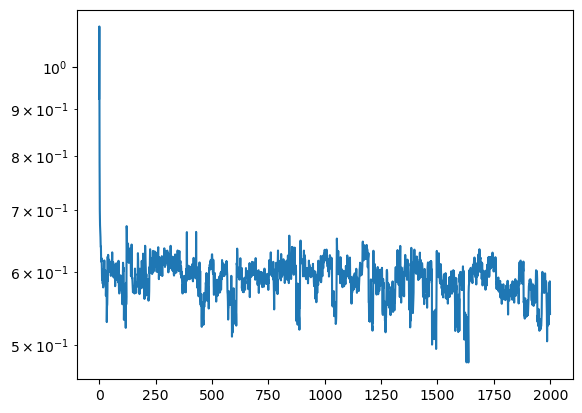

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 


  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [00:02<00:49,  2.61s/it]


 10%|█         | 2/20 [00:05<00:49,  2.74s/it]


 15%|█▌        | 3/20 [00:08<00:50,  3.00s/it]


 20%|██        | 4/20 [00:11<00:47,  2.97s/it]


 25%|██▌       | 5/20 [00:14<00:46,  3.10s/it]


 30%|███       | 6/20 [00:18<00:42,  3.07s/it]


 35%|███▌      | 7/20 [00:21<00:39,  3.06s/it]


 40%|████      | 8/20 [00:24<00:36,  3.06s/it]


 45%|████▌     | 9/20 [00:27<00:33,  3.04s/it]


 50%|█████     | 10/20 [00:30<00:30,  3.01s/it]


 55%|█████▌    | 11/20 [00:33<00:27,  3.09s/it]


 60%|██████    | 12/20 [00:36<00:24,  3.07s/it]


 65%|██████▌   | 13/20 [00:39<00:21,  3.06s/it]


 70%|███████   | 14/20 [00:42<00:17,  2.97s/it]


 75%|███████▌  | 15/20 [00:44<00:14,  2.91s/it]


 80%|████████  | 16/20 [00:47<00:11,  2.95s/it]


 85%|████████▌ | 17/20 [00:50<00:08,  2.95s/it]


 90%|█████████ | 18/20 [00:53<00:05,  2.93s/it]


 95%|█████████▌| 19/20 [00:56<00:02,  2.83s/it]


100%|██████████| 20/20 [00:58<00:00,  2.76s/it]


100%|██████████| 20/20 [00:58<00:00,  2.95s/it]

Test Loss: 0.5901


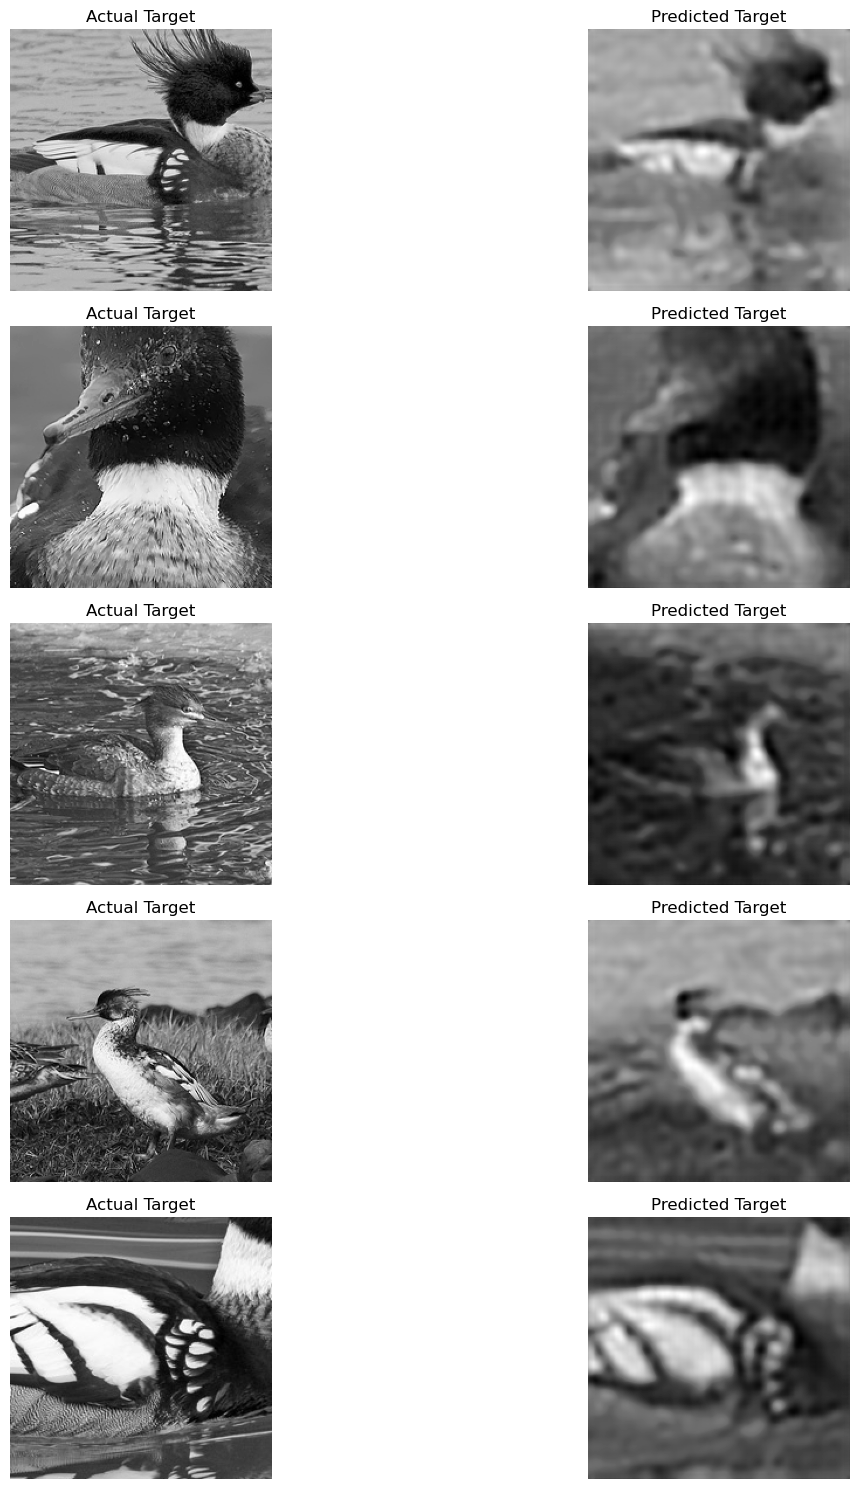

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-5.2898) tensor(5.5899)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))